# AGN light curve Pipeline
This code is a pipeline to generate simulated AGN light curve based on Kelly 2009.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker181
import pandas as pd
from matplotlib.ticker import ScalarFormatter
from scipy.integrate import quad, dblquad
from tqdm import tqdm
#import psi 
from astroML.time_series import generate_power_law
from astroML.fourier import PSD_continuous
from scipy.signal import convolve
import csv
import astropy
import astropy.units as u
from dust_extinction.averages import G03_SMCBar
from photutils.detection import find_peaks
from astropy.io import fits
from photutils.aperture import CircularAperture, aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
import os
import gzip
import shutil
from scipy.interpolate import interp1d

# Constants, try to keep them in SI units
G = 6.674e-11  # Universal gravitational constant (m^3 kg^-1 s^-2)
c     = 2.9979e8 # Speed of light
M_sol   = 1.989e30 # Solar mass in kg
ld    = 2.59e13 # Light day in m
sigma = 5.67e-8 # Stefan-Boltzmann constant
h    = 6.626e-34 # Planck constant
k   = 1.38e-23 # Boltzmann constant

## Observational Wavelengths

In [2]:
wavref = [3650,4640,6580,8060,9000,10200]

def deredshift(wav, z):
    return np.array(wav)/(1+z)

print(deredshift(wavref, 2))

deredshift_wav05 = [2433, 3093, 4387, 5373, 6000, 6800]
deredshift_wav1 = [1825, 2320, 3290, 4030, 4500, 5100]
deredshift_wav2 = [1216, 1546, 2193, 2686, 3000, 3400]

[1216.66666667 1546.66666667 2193.33333333 2686.66666667 3000.
 3400.        ]


## Damped Random Walk Functions
Here are a set of functions used to generate the DRW light curve. The generate_DRW function requires the relaxation time and the standard deviation of the light curve at short time scale. The calculation for these two values requires the mass of the SMBH and luminosity of the AGN. The luminosity is calulated as a fraction of the Eddington luminosity.


In [3]:
def relaxation_time(M, L, lam = 1):
    """
    Calculate the relaxation time of an AGN using the relation from Kelly et al. 2009.
    Parameters
    ----------
    M (float): Black hole mass in kg
    L (float): Luminosity_lam in erg/s*m
    lam (float): Wavelength; default=1
    """
    M=M/M_sol
    tau_relax = 80.4*((lam*L/(10**45))**(-0.42)) * ((M/10**8)**1.03)
    
    ### Need correcting
    tau_relax_error = tau_relax - (80.4+66.9)*(lam*L/(10**45))**(-0.42+0.28) * (M/10**8)**(1.03+0.38)
    return tau_relax, tau_relax_error    

def drw_sigma(M, L, lam = 1):
    """
    Calculate the long-term variation amplitude of an AGN using the relation from Kelly et al. 2009.
    Parameters
    ----------
    M (float): Black hole mass in Kg
    L (float): Luminosity_lam in erg/s*m
    lam (float): Wavelength; default=1
    """
    M=M/M_sol
    log_sigma2 = -3.83-0.09*np.log(lam*L/10**45) * -0.25*np.log(M/10**8)
    sigma = np.sqrt(10**log_sigma2)

    ### Need correcting
    sigma_error = sigma - (0.18+0.11)*(lam*L/(10**45))**(0.18-0.09) * (M/10**8)**(0.18+0.09)
    return sigma, sigma_error

def eddington_acc(M, effi = 0.1):
    """
    Calculate the Eddington accretion rate of an AGN.
    Parameters
    ----------
    M (float): Black hole mass in kg
    effi (float): Eddington efficiency; default=0.1
    """
    M_p = 1.6726219e-27 # Proton mass in kg
    t_cross_sec = 6.6524587e-29 # Thomson cross section in m^2
    M_dot = 4*np.pi*G*M*M_p/(effi*c*t_cross_sec) # Eddington accretion rate in kg/s
    return M_dot


def generate_DRW(t_rest,mean_flux=0 ,tau=200,z=0,b=0,sigma=0.03,seed=0):
    """
    Simulates an AGN light curve using the Damped Random Walk (DRW) model (Kelly 2009).

    Parameters
    ----------
    t_rest (array_like): rest-frame time (sorted).  
    mean_flux (float): mean flux; default=10
    tau (float): relaxation time
    z (float): redshift
    mean_vari (float): mean light curve variation; default=0
    b (float): mean variation amplitude; default=0
    sigma (float): long-term variation amplitude; default=1
    seed (int): random seed for np.random

    Returns
    -------
    x (ndarray): Flux values at each time in t_rest
    """
    np.random.seed(seed)
    mean_vari = b * tau
    variance = sigma * np.sqrt(tau / 2)

    N = len(t_rest)

    t_obs = t_rest * (1 + z) / tau

    x = np.zeros(N)
    x[0] = np.random.normal(mean_vari, variance)
    epsilon = np.random.normal(0, 1, N) # White noise
    #dX(t) = -X(t) * dt + sigma * sqrt(tau) * e(t) * sqrt(dt) + b * tau * dt
    #Xmean = b * tau
    #SFinf = sigma * sqrt(tau / 2)
    
    for i in range(1, N):
        dt = t_obs[i] - t_obs[i - 1]
        x[i] = (x[i - 1] - dt * (x[i - 1] - mean_vari) 
                + sigma * np.sqrt(tau) * epsilon[i] * np.sqrt(dt)
                +b * tau * dt)

    x = x + mean_flux
    t_obs = t_rest * (1 + z)
    return x,t_obs

## Flux Calculation Functions

In [4]:
def absolute_magnitude(luminosity, L_sun=3.828e26 * 10**7, M_sun=4.83):
    """
    Calculate the absolute magnitude of an astronomical object given its luminosity.
    
    Parameters:
    ----------
    - luminosity (float): The luminosity of the object in watts.
    - L_sun (float, optional): The luminosity of the Sun in watts. Default is 3.828e26 * 10**7 erg/s.
    - M_sun (float, optional): The absolute magnitude of the Sun. Default is 4.83.
    
    Returns:
    ----------
    - float: The absolute magnitude of the object.
    """
    return M_sun - 2.5 * np.log10(luminosity / L_sun)

def fvf_cal(sfinf,avg_flux):
    '''
    Calculate the fractional variability amplitude from the structure function

    Parameters
    ----------
    sfinf (float): Structure function at infinity
    avg_flux (float): Average flux of the light curve

    Returns
    -------
    fvf (float): Fractional variability amplitude
    '''
    fvf = np.sqrt(sfinf/2)/avg_flux
    return fvf

def flux_to_magnitude(flux_mJy, F0=3631):
    """
    Convert flux in millijanskys (mJy) to astronomical magnitude.

    Parameters:
    ----------
    - flux_mJy (float): Flux in millijanskys.
    - F0 (float, optional): Zero-point flux density in Janskys. Default is 3631 Jy.

    Returns:
    ----------
    - float: Magnitude.
    """
    
    return -2.5 * np.log10(flux_mJy / F0)

def fnu_to_abmag(fnu):
    return -2.5 * np.log10(fnu) - 48.6

def mac10_sf(M_BH, M_i, lambda_RF):
    """
    Computes the log structure function SF_infinity using Equation 7 from MacLeod et al. (2012).

    Parameters:
    ----------
    M_BH (float): Black hole mass in solar masses.
    M_i (float): Absolute i-band magnitude.
    lambda_RF (float): Rest-frame wavelength in Angstroms.

    Returns:
    ----------
    float: SF_infinity
    """
    # Constants from MacLeod et al. (2012)
    A = -0.51
    B = -0.479
    C = 0.131
    D = 0.18

    # Compute log SF_infinity
    log_SF_inf = (A + 
                  B * np.log10(lambda_RF / 4000) + 
                  C * (M_i + 23) + 
                  D * np.log10(M_BH / 1e9))
    
    return 10**log_SF_inf

def mac10_tau(M_BH, M_i, lambda_RF):
    """
    Computes the log tau using Equation 7 from MacLeod et al. (2012).
    
    Parameters:
    ----------
    M_BH (float): Black hole mass in solar masses.
    M_i (float): Absolute i-band magnitude.
    lambda_RF (float): Rest-frame wavelength in Angstroms.
    
    Returns:
    ----------
    float: tau [days]
    """
    # Constants from MacLeod et al. (2012)
    A = 2.4
    B = 0.17
    C = 0.03
    D = 0.21

    # Compute log SF_infinity
    log_tau = (A + 
                  B * np.log10(lambda_RF / 4000) + 
                  C * (M_i + 23) + 
                  D * np.log10(M_BH / 1e9))
    
    return 10**log_tau

# Constants from the paper for different time scales
BEST_FIT_PARAMS = {
    "M": {  # log(variance) = a * log(M/M_8.5) + b
        300: {"a": -0.13, "b": -2.85},  # 300d time-scale
        150: {"a": -0.35, "b": -3.06},  # 150d time-scale
        75: {"a": -0.66, "b": -3.24},   # 75d time-scale
        30: {"a": -1.03, "b": -3.66},   # 30d time-scale
    },
    "R_Edd": {  # log(variance) = a * log(R_Edd/0.1) + b
        300: {"a": -0.53, "b": -2.89},
        150: {"a": -0.62, "b": -3.08},
        75: {"a": -0.74, "b": -3.25},
        30: {"a": -0.95, "b": -3.64},
    },
    "L_bol": {  # log(variance) = a * (log(L_bol) - 45.8) + b
        300: {"a": -0.33, "b": -3.01},
        150: {"a": -0.53, "b": -3.25},
        75: {"a": -0.76, "b": -3.48},
        30: {"a": -1.01, "b": -3.95},
    },
}

# Reference values
REF_VALUES = {
    "M": 10**8.5,  # Reference mass in solar masses
    "R_Edd": 0.1,  # Reference Eddington ratio
    "L_bol": 10**45.8,  # Reference luminosity in erg/s
}


def compute_variance(X, X_type, time_scale):
    """
    Compute the variance using the best-fit linear model from Arevalo et al. (2023).

    Parameters:
    X (float): The independent variable (M, R_Edd, or L_bol).
    X_type (str): The type of variable ("M", "R_Edd", or "L_bol").
    time_scale (int): The time scale in days (30, 75, 150, or 300).

    Returns:
    float: The computed variance.
    """
    if X_type not in BEST_FIT_PARAMS:
        raise ValueError(f"Invalid X_type. Choose from {list(BEST_FIT_PARAMS.keys())}")
    if time_scale not in BEST_FIT_PARAMS[X_type]:
        raise ValueError(f"Invalid time scale. Choose from {list(BEST_FIT_PARAMS[X_type].keys())}")

    a = BEST_FIT_PARAMS[X_type][time_scale]["a"]
    b = BEST_FIT_PARAMS[X_type][time_scale]["b"]
    X0 = REF_VALUES[X_type]

    log_variance = a * (np.log10(X) - np.log10(X0)) + b
    return 10**log_variance  # Convert log(variance) back to variance


### Fiducial AGN
We will use a fiducial AGN with mass of 1e8.5 solar mass and 10% Eddington Lumonosity at z=0.5, 1, and, 2.

In [5]:
# Time points 
days = np.arange(0.0,10 * 365,1) # 1 day sampling for 10 years

M = 10**8.5 * M_sol # Black hole mass in kg
M_dot = 1*M_sol/(365*24*3600) # kg per second
M_dot_edd = eddington_acc(M)*0.1 # 10% Eddington accretion rate
L = (0.1 * M_dot_edd * c**2) * 10**7 # erg/s
abs_mag = absolute_magnitude(L)

DRW_sigma = drw_sigma(10**8,L)[0]
tau_relax = relaxation_time(M,L)[0]

print('1 M_sol per year [Kg/s]:',f'{M_dot:.3e}'
      ,'\n10% Eddington Accretion [kg/s]: ' , f'{eddington_acc(M)*0.1:.3e}')
print('Luminosity [erg/s]: ',f'{L:.3e}')
print('Absolute Magnitude: ',round(abs_mag,4))

print('\nKelly 2009 DRW parameters:')
print('Relaxation Time [days]: ',round(tau_relax,4))
print('Sigma: ',round(DRW_sigma,4))
print('SFinf', DRW_sigma * np.sqrt(tau_relax / 2))

print('\nMacLeod 2010 DRW parameters:')
print('Relaxation Time [days]: ',round(mac10_tau(M/M_sol,abs_mag,4000),4))
print('SFinf: ',round(mac10_sf(M/M_sol,abs_mag,4000),4))

print('\nArevalo 2023 Variance')
print('Variance 30 days: ',round(compute_variance(M/M_sol, "M", 300),4))
print('SFinf: ',(2*compute_variance(M/M_sol, "M", 300)**2))


1 M_sol per year [Kg/s]: 6.307e+22 
10% Eddington Accretion [kg/s]:  4.424e+22
Luminosity [erg/s]:  3.976e+45
Absolute Magnitude:  -25.2112

Kelly 2009 DRW parameters:
Relaxation Time [days]:  147.3945
Sigma:  0.001
SFinf 0.008617340127081579

MacLeod 2010 DRW parameters:
Relaxation Time [days]:  169.3024
SFinf:  0.1289

Arevalo 2023 Variance
Variance 30 days:  0.0014
SFinf:  3.990524629937757e-06


In [6]:
# Time points 
days_rest = np.arange(0.0,5 * 365+1,1) # 1 day sampling for 3 years

# Time dilated sampling to ensure correct imaging sampling
# Each time is more densely sampled to ensure that when dilated
# the sampling is consistent across all redshifts
days_z05 = np.arange(0.0,5 * 365,1/(1+0.5)) # 1 day sampling for 5 years
days_z1 = np.arange(0.0,5 * 365,1/(1+1)) # 1 day sampling for 5 years
days_z2 = np.arange(0.0,5 * 365,1/(1+2)) # 1 day sampling for 5 years
# We will trim later

days_z05_obs = days_rest*(1+0.5)
days_z1_obs = days_rest*(1+1)
days_z2_obs = days_rest*(1+2)

end = 10

print(days_rest[0:20],len(days_rest))
print(days_z05[0:end],len(days_z05))
print(days_z1[0:end],len(days_z1))
print(days_z2[0:end], len(days_z2),'\n') 

print(days_z05_obs[0:end])
print(days_rest[0:end*3:3])
print(days_z1_obs[0:end])
print(days_rest[0:end*3:4])
print(days_z2_obs[0:end], len(days_z2_obs))
print(days_rest[0:end*3:6])

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.] 1826
[0.         0.66666667 1.33333333 2.         2.66666667 3.33333333
 4.         4.66666667 5.33333333 6.        ] 2738
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5] 3650
[0.         0.33333333 0.66666667 1.         1.33333333 1.66666667
 2.         2.33333333 2.66666667 3.        ] 5475 

[ 0.   1.5  3.   4.5  6.   7.5  9.  10.5 12.  13.5]
[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
[ 0.  4.  8. 12. 16. 20. 24. 28.]
[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.] 1826
[ 0.  6. 12. 18. 24.]


Time dilation stop-gap solution:

Generate driving light curve with cadence of 0.5 day.

At each redshift, t_obs = t_rest * (1+z) [z=0.5, 1 = 1.5]

Therefore, we sample every 1.5th point would be equivalent to sampling every 0.5 day at z=0.5. The first data point (1.5 days) is the 3rd point in the driving light curve. ie sample every 3 points

At z=1, first data point (2 days) is the 4th point in the driving light curve. ie sample every 4 points.

### Generate DRW light curve

5475 1826
1826 1826 1826 1826
1826 1826 1826 1826
5475.0


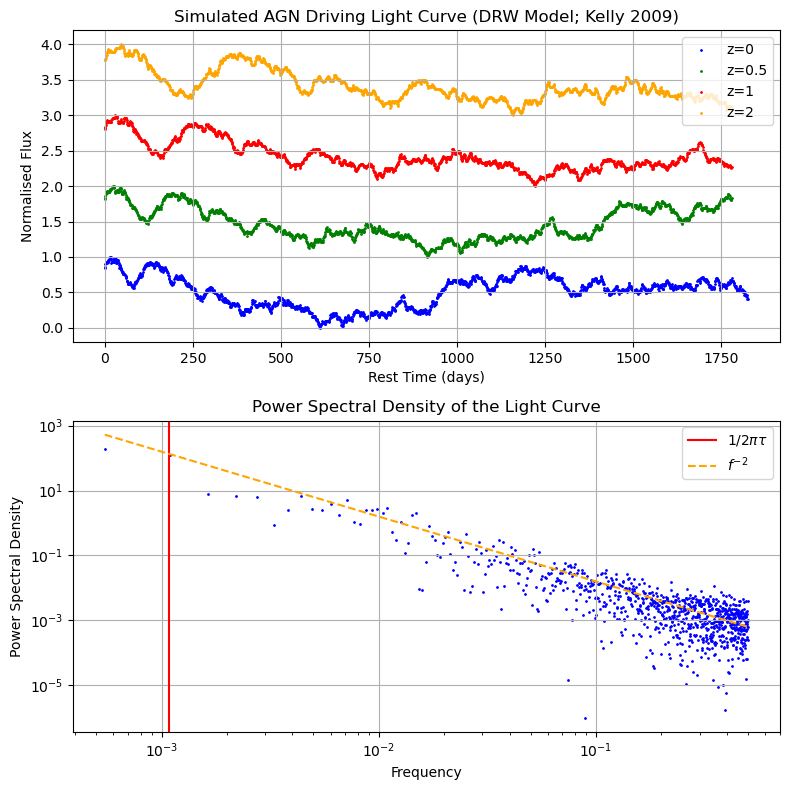

In [23]:
light_curve_rest, t_obs = generate_DRW(days_rest,tau = tau_relax,sigma=DRW_sigma, z=0.0, seed=0)
light_curve_z05, t_obs_z05 = generate_DRW(days_z05_obs,tau = tau_relax,sigma=DRW_sigma, z=0, seed=0)
light_curve_z1, t_obs_z1 = generate_DRW(days_z1_obs,tau = tau_relax,sigma=DRW_sigma, z=0, seed=0)
light_curve_z2, t_obs_z2 = generate_DRW(days_z2_obs,tau = tau_relax,sigma=DRW_sigma, z=0, seed=0)



print(len(days_z2),len(light_curve_z2))

days_interp = np.arange(0.0,356*5,1) # 1 day sampling for 5 years
interp_func = interp1d(days_z2_obs, light_curve_z2, kind='linear', fill_value='extrapolate')
interpolated_lc_z2 = interp_func(days_interp)

interp_func = interp1d(days_z1_obs, light_curve_z1, kind='linear', fill_value='extrapolate')
interpolated_lc_z1 = interp_func(days_interp)

interp_func = interp1d(days_z05_obs, light_curve_z05, kind='linear', fill_value='extrapolate')
interpolated_lc_z05 = interp_func(days_interp)

#print(interpolated_lc)

def normalise(light_curve_data):
    return (light_curve_data - np.min(light_curve_data)) / (np.max(light_curve_data) - np.min(light_curve_data))

normalised_lc_rest = normalise(light_curve_rest)
normalised_lc_z05 = normalise(light_curve_z05)
normalised_lc_z1 = normalise(light_curve_z1)
normalised_lc_z2 = normalise(light_curve_z2)

normalised_interpt_lc_z2 = normalise(interpolated_lc_z2)
normalised_interpt_lc_z1 = normalise(interpolated_lc_z1)
normalised_interpt_lc_z05 = normalise(interpolated_lc_z05)


# Compute the power spectral density
f, PSD = PSD_continuous(days_rest, light_curve_rest)
alpha = PSD[-1] / f[-1]**-2

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot the simulated light curve


axs[0].scatter(days_rest[:], normalised_lc_rest[:], s=1, color='blue', marker='o', label='z=0')
axs[0].scatter(days_interp[:], normalised_interpt_lc_z05[:]+1, s=1, color='green', marker='o', label='z=0.5')
axs[0].scatter(days_interp[:], normalised_interpt_lc_z1[:]+2, s=1,  color='red', marker='o', label='z=1')
axs[0].scatter(days_interp[:], normalised_interpt_lc_z2[:]+3, s=1,  color='orange', marker='o', label='z=2')

#axs[0].scatter(days_rest[:], normalised_lc_rest[:], s=1, color='blue', label='z=0')
#axs[0].scatter(days_rest[::3], normalised_lc_rest[::3]+1, s=1, color='green', label='z=0.5')
#axs[0].scatter(days_rest[::4], normalised_lc_rest[::4]+2, s=1, color='red', label='z=1')
#axs[0].scatter(days_rest[::6], normalised_lc_rest[::6]+3, s=1, color='orange', label='z=2')

#axs[0].scatter(days_z05_obs, normalised_lc_rest+1, s=30, color='green', label='z=0.5')
#axs[0].scatter(days_z1_obs, normalised_lc_rest+2, s=30, color='red', label='z=1')

#axs[0].plot(days_rest, normalised_interpt_lc_z2+3, color='black', linestyle='--' ,label='Interpolated z=2')

#axs[0].scatter(days_z2_obs[:1825], normalised_interpt_lc_z2, s=10, color="black")
#axs[0].scatter(days_z2_obs, normalised_lc_rest, s=10,alpha=0.5 , color='orange', label='z=2')

#axs[0].scatter(days_z2_obs[:1825], interpolated_lc[::3], s=10, color="black")
#axs[0].scatter(days_z2_obs, light_curve_z2, s=10,color='orange', label='z=2')
print(len(days_rest),len(days_z05_obs),len(days_z1_obs),len(days_z2_obs))
print(len(days_rest),len(days_z05_obs),len(days_z1_obs),len(days_z2_obs))
print(days_z2_obs[1825])


#axs[0].scatter(days_z05[::3], normalised_lc_z05[::3]-0.05, s=30, marker='x', color='black', label='z=0.5')
#axs[0].scatter(days_z1[::4], normalised_lc_z1[::4]-0.1, s=30, marker='x', color='black', label='z=1')
#axs[0].scatter(days_z2[::6], normalised_lc_z2[::6]-0.15, s=30, marker='x', color='black', label='z=2')
#axs[0].scatter(days_z05[::3], normalised_lc_z05[::3]-0.05, s=30, marker='x', color='black', label='z=0.5')
#axs[0].scatter(days_z1[::4], normalised_lc_z1[::4]-0.1, s=30, marker='x', color='black', label='z=1')
#axs[0].scatter(days_z2[::6], normalised_lc_z2[::6]-0.15, s=30, marker='x', color='black', label='z=2')
#print(len(normalised_lc_z05[::3]),len(normalised_lc_z1[::4]),len(normalised_lc_z2[::6]))
axs[0].set_xlabel('Rest Time (days)')
axs[0].set_ylabel('Normalised Flux')
axs[0].set_title('Simulated AGN Driving Light Curve (DRW Model; Kelly 2009)')
axs[0].grid(True)
axs[0].legend()
#axs[0].set_xlim(0,3*365)

# Plot the power spectral density
axs[1].scatter(f, PSD, s=1, color='blue')
axs[1].axvline(1/(2*np.pi*tau_relax), color='red', label=r'1/2$\pi\tau$')
# Plot a line proportional to frequency^-2 for comparison
axs[1].loglog(f[1:], alpha*(f[1:]**-2), label=r'$f^{-2}$', linestyle='--', color='orange')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Power Spectral Density')
axs[1].set_title('Power Spectral Density of the Light Curve')
axs[1].grid(True)
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

## Temperature Profile & Disc Continuum Emission
In order to calculate the measured flux, we need to know the continuum emission from the disc. We assume the disc to be geometrically thin and optically thick. The continuum spectrum is given by the sum of the blackbody spectrum at each radius of the disc.

In [8]:
def temp_r(radius, M, M_dot, hx, albedo, efficiency, r_in):
    """
    Calculate the temperature of an accretion disk at a given radius.

    Parameters
    ----------
    radius (float): radius in light days
    M (float): mass of the black hole in solar masses
    M_dot (float): accretion rate in solar masses per year
    hx (float): height of the disk at the radius in gravitational radii
    albedo (float): albedo of the disk
    efficiency (float): efficiency parameter
    """
    M_sol   = 1.989e30  # Solar mass in kg
    ld    = 2.59e13 # Light day in m

    rs    = 2*G*M/c**2 # Schwarzschild radius in m
    r_in = r_in*rs # Inner radius of the disk in m
    hx    = hx*rs # Height of lamp in m
    Lb    = efficiency*M_dot*c**2 # Luminosity of the disk in W

    temp_vis = (3*G*M*M_dot/(8*np.pi*sigma*radius**3)*(1-np.sqrt(r_in/radius)))**(1/4)
    temp_irr = ((1 - albedo)*(hx*Lb)/(4*np.pi*sigma*(np.sqrt((radius**2)+(hx**2)))**3))**(1/4)
    temp_tot = ((3*G*M*M_dot/(8*np.pi*sigma*radius**3)*(1-np.sqrt(r_in/radius))) 
             + ((1 - albedo)*(hx*Lb)/(4*np.pi*sigma*(np.sqrt(((radius)**2)+(hx**2)))**3)) )**(1/4)
    return temp_tot, temp_vis, temp_irr


def weins_law(T): #angstrom
    return  0.0029* 1e10/T 

def grav_radius(M): # Mass in Kg
    return 2*G*M/c**2

### Starkey 2016 Fig 1, R_in = Rs
Here we reproduced Starkey 2016 plot for 1e8 M_sol and 1M_dot AGN with R_in = Rs.

Gravitational Radius [m]:  295404221161.55774


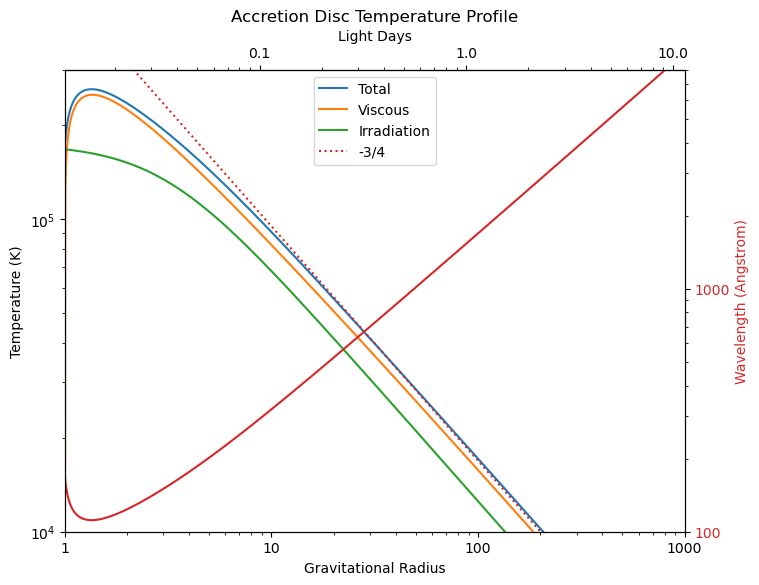

In [9]:
M_sol   = 1.989e30  # Solar mass in kg
ld    = 2.59e13 # Light day in m

M=10**8 # Solar masses
M = M*M_sol # Black hole mass in kg

M_dot= 1 # Solar masses per year
M_dot = M_dot*M_sol/(365*24*3600) # Accretion rate in kg/s 

hx= 3 # Gravitational radii
albedo= 0.1 # Albedo
efficiency= 0.1 # accretion efficiency
rs    = grav_radius(M) # Schwarzschild radius in m
r_in = 1 # Inner radius of the disk in gravitational radii

def ld2rg(x):
    return (x*2.59e13)/(rs)
def rg2ld(x):
    return (x*rs)/2.59e13

print('Gravitational Radius [m]: ',rs)
radii = np.logspace(np.log10(rs+1), np.log10(rs*1000), 1000) #m
temp_prof, temp_vis, temp_irr = temp_r((radii), (M),(M_dot),hx,albedo,efficiency,r_in)

emitting_lambda = weins_law(temp_prof)

# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
axs.plot(radii/rs, temp_prof, label='Total')
axs.plot(radii/rs, temp_vis, label='Viscous')
axs.plot(radii/rs, temp_irr, label='Irradiation')
axs.plot(radii/rs, (3e0*(radii[999]/rs)/(radii[999]/rs)**(-3/4))*(radii/rs)**(-3/4)
         , label='-3/4', linestyle=':')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Gravitational Radius')
axs.set_ylabel('Temperature (K)')
axs.set_title('Accretion Disc Temperature Profile')
axs.xaxis.set_major_formatter(ScalarFormatter())
axs.set_ylim(1e4, 3e5)
axs.set_xlim(1, 1000)
axs.legend(loc='upper center')
#axs.axvline(rg2ld(3))
#minor_locator = ticker.MultipleLocator(5e3)  # Set minor ticks every 0.5 units
#axs.yaxis.set_major_locator(minor_locator)
ax2 = axs.twinx() 
 
color = 'tab:red'
ax2.set_ylabel('Wavelength (Angstrom)',color = color) 
ax2.plot(radii/rs, emitting_lambda,color = color) 
ax2.tick_params(axis ='y',labelcolor  = color) 
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.set_ylim(100,8000)
#
secax = axs.secondary_xaxis('top', functions=(rg2ld,ld2rg ))
secax.set_xlabel('Light Days')
secax.set_xlim(1,1000)
secax.xaxis.set_major_formatter(ScalarFormatter())

### Fiducial AGN with R_in = 3 Rs

Temperature at R0 [k]:  21913.960554005356
Gravitational Radius [m]:  934150169298.6335
Light Days [m]:  25900000000000.0
27.725734952706695
52887 58560 66769 71510 74085


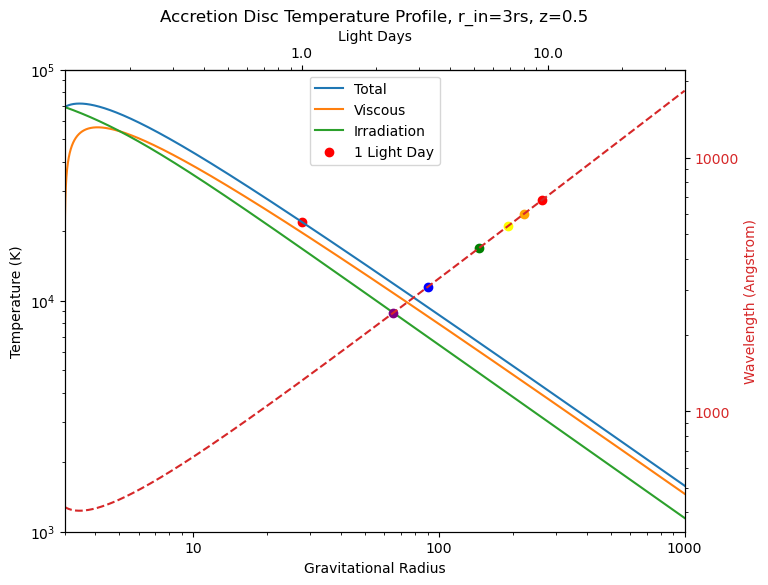

In [10]:
# Time points 
days = np.arange(0.0,10 * 365,1) # 1 day sampling for 10 years

M = 10**8.5 * M_sol # Black hole mass in kg

M_dot_edd = eddington_acc(M)*0.1 # kg per second
L = (0.1 * M_dot_edd * c**2) * 10**7 # erg/s
#M_dot = 1*M_sol/(365*24*3600) # kg per second
#L = (0.1 * M_dot * c**2) * 10**7 # erg/s

DRW_sigma = drw_sigma(10**8,L)[0]
tau_relax = relaxation_time(M,L)[0]

hx= 3 # Gravitational radii
albedo= 0.1 # Albedo
efficiency= 0.1 # accretion efficiency
rs    = 2*G*M/c**2 # Schwarzschild radius in m
r_in = 3 # Inner radius of the disk in gravitational radii

def ld2rg(x):
    return (x*2.59e13)/(rs)
def rg2ld(x):
    return (x*rs)/2.59e13

radii = np.logspace(np.log10(r_in*rs+1), np.log10(rs*1000), 100000) #m
temp_prof, temp_vis, temp_irr = temp_r((radii), (M),(M_dot_edd),hx,albedo,efficiency,r_in)

# Temperature at R0
temp_r0_index = np.where(radii >= ld)[0]
temp_r0 = temp_prof[temp_r0_index[0]]
print('Temperature at R0 [k]: ',temp_r0)
print('Gravitational Radius [m]: ',rs)
print('Light Days [m]: ',ld)
print(ld/rs)
emitting_lambda = weins_law(temp_prof)


# Rest Frame Wavelength
wav_index1 = np.where(emitting_lambda >= deredshift_wav05[0])[0]
wav_index2 = np.where(emitting_lambda >= deredshift_wav05[1])[0]
wav_index3 = np.where(emitting_lambda >= deredshift_wav05[2])[0]
wav_index4 = np.where(emitting_lambda >= deredshift_wav05[3])[0]
wav_index5 = np.where(emitting_lambda >= deredshift_wav05[4])[0]
wav_index6 = np.where(emitting_lambda >= deredshift_wav05[5])[0]
print(wav_index1[0],wav_index2[0],wav_index3[0],wav_index4[0],wav_index5[0])   



# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
axs.plot(radii/rs, temp_prof, label='Total')
axs.plot(radii/rs, temp_vis, label='Viscous')
axs.plot(radii/rs, temp_irr, label='Irradiation')
axs.scatter(radii[temp_r0_index[0]]/rs, temp_r0, label='1 Light Day', color='red')
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Gravitational Radius')
axs.set_ylabel('Temperature (K)')
axs.set_title('Accretion Disc Temperature Profile, r_in=3rs, z=0.5')
axs.xaxis.set_major_formatter(ScalarFormatter())
axs.set_ylim(1e3, 1e5)
axs.set_xlim(r_in, 1000)
axs.legend(loc='upper center')
#axs.axvline(rg2ld(3))
#minor_locator = ticker.MultipleLocator(5e3)  # Set minor ticks every 0.5 units
#axs.yaxis.set_major_locator(minor_locator)
ax2 = axs.twinx() 
 
color = 'tab:red'
ax2.set_ylabel('Wavelength (Angstrom)',color = color) 
ax2.plot(radii/rs, emitting_lambda,color = color, linestyle='--') 
ax2.scatter(radii[wav_index1[0]]/rs, emitting_lambda[wav_index1[0]],color = 'purple')
ax2.scatter(radii[wav_index2[0]]/rs, emitting_lambda[wav_index2[0]],color = 'blue')
ax2.scatter(radii[wav_index3[0]]/rs, emitting_lambda[wav_index3[0]],color = 'green')
ax2.scatter(radii[wav_index4[0]]/rs, emitting_lambda[wav_index4[0]],color = 'yellow')
ax2.scatter(radii[wav_index5[0]]/rs, emitting_lambda[wav_index5[0]],color = 'orange')
ax2.scatter(radii[wav_index6[0]]/rs, emitting_lambda[wav_index6[0]],color = 'red')
ax2.tick_params(axis ='y',labelcolor  = color) 
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
#ax2.set_ylim(100,8000)

#
secax = axs.secondary_xaxis('top', functions=(rg2ld,ld2rg ))
secax.set_xlabel('Light Days')
secax.set_xlim(1,1000)
secax.xaxis.set_major_formatter(ScalarFormatter())


### Continuum Spectrum

In [11]:
inclination = 0

# Distances [mpc] omega_m = 0.3, omega_lambda = 0.7, h = 0.7, wright 2006
z05_mpc = 1888.5
z1_mpc = 3303.5
z2_mpc = 5179.0


def Mpc2Cm(d):
    return d*3.086e24

z05_cm = Mpc2Cm(z05_mpc) 
z1_cm = Mpc2Cm(z1_mpc)
z2_cm = Mpc2Cm(z2_mpc)

print('redshifts: ',0.5,1,2)
print('Distance [Mpc]: ',z05_mpc,z1_mpc,z2_mpc)	
print('Distance [cm]: ',z05_cm,z1_cm,z2_cm)

erg = 1e7 # J to erg

# Define the Planck function, F_nu
def planck_function(freq, temp):
    # Computes black body intensity (J/m^2/s/Hz/sr) at given temperature and frequency.

    c1 = (2 * k**3)/(c**2 * h**2) # (2kb^3)/(c^2h^2)
    c2 = h / k # h/kb
    
    x = c2 * freq / temp

    if (x < 1e-5): # Rayleigh-Jeans tail
        Planck = c1*(x**2)*(temp**3)
    else:
        Planck = c1*(x**3)*(temp**3) / (np.expm1(x))
    return Planck

# Define the integrand for the emitted spectrum
def integrand(r, lam, inclination, distance):
    # Return spectrum in erg/s/cm^2/Hz
    temp_prof, _, _ = temp_r(r, M, M_dot, hx, albedo, efficiency, r_in)
    if np.isnan(temp_prof):
        return 0
    freq = c / lam
    return planck_function(freq, temp_prof)* erg * 2 * np.pi * r * np.cos(inclination) / distance**2

# Define the wavelength range (in meters)
#wavelengths = np.linspace((1e-8), (1e-3), 10000)  # Wavelength in meters
#wavelengths = np.logspace(np.log10(1e-8), np.log10(1e-3), 10000)  # Wavelength in meters
wavelengths = np.arange(1e-8,1e-4,1e-9)
# Define the radius range (in rs)
r_min = rs*3 #m
r_max = (rs*1000) #m


# Compute the emitted spectrum by integrating over the radius range
emitted_spectrum_z05 = []
emitted_spectrum_z1 = []
emitted_spectrum_z2 = []
for lam in wavelengths:
    spectrum_z05, _ = quad(integrand, r_min, r_max, args=(lam, inclination, z05_cm,),limit=100)
    spectrum_z1, _ = quad(integrand, r_min, r_max, args=(lam, inclination, z1_cm,),limit=100)
    spectrum_z2, _ = quad(integrand, r_min, r_max, args=(lam, inclination, z2_cm,),limit=100)
    #spectrum = spectrum*()
    emitted_spectrum_z05.append(spectrum_z05)
    emitted_spectrum_z1.append(spectrum_z1)
    emitted_spectrum_z2.append(spectrum_z2)

# Convert the emitted spectrum to a numpy array
emitted_spectrum_z05 = np.array(emitted_spectrum_z05)
emitted_spectrum_z1 = np.array(emitted_spectrum_z1)
emitted_spectrum_z2 = np.array(emitted_spectrum_z2)

redshifts:  0.5 1 2
Distance [Mpc]:  1888.5 3303.5 5179.0
Distance [cm]:  5.827911e+27 1.0194601e+28 1.5982393999999998e+28


C:\Users\nikko\AppData\Local\Temp\ipykernel_26096\259154850.py:34: RuntimeWarning: overflow encountered in expm1
  Planck = c1*(x**3)*(temp**3) / (np.expm1(x))


Here we plot the continuum spectrum in the rest frame with the centre of each bandpass marked on the spectrum.

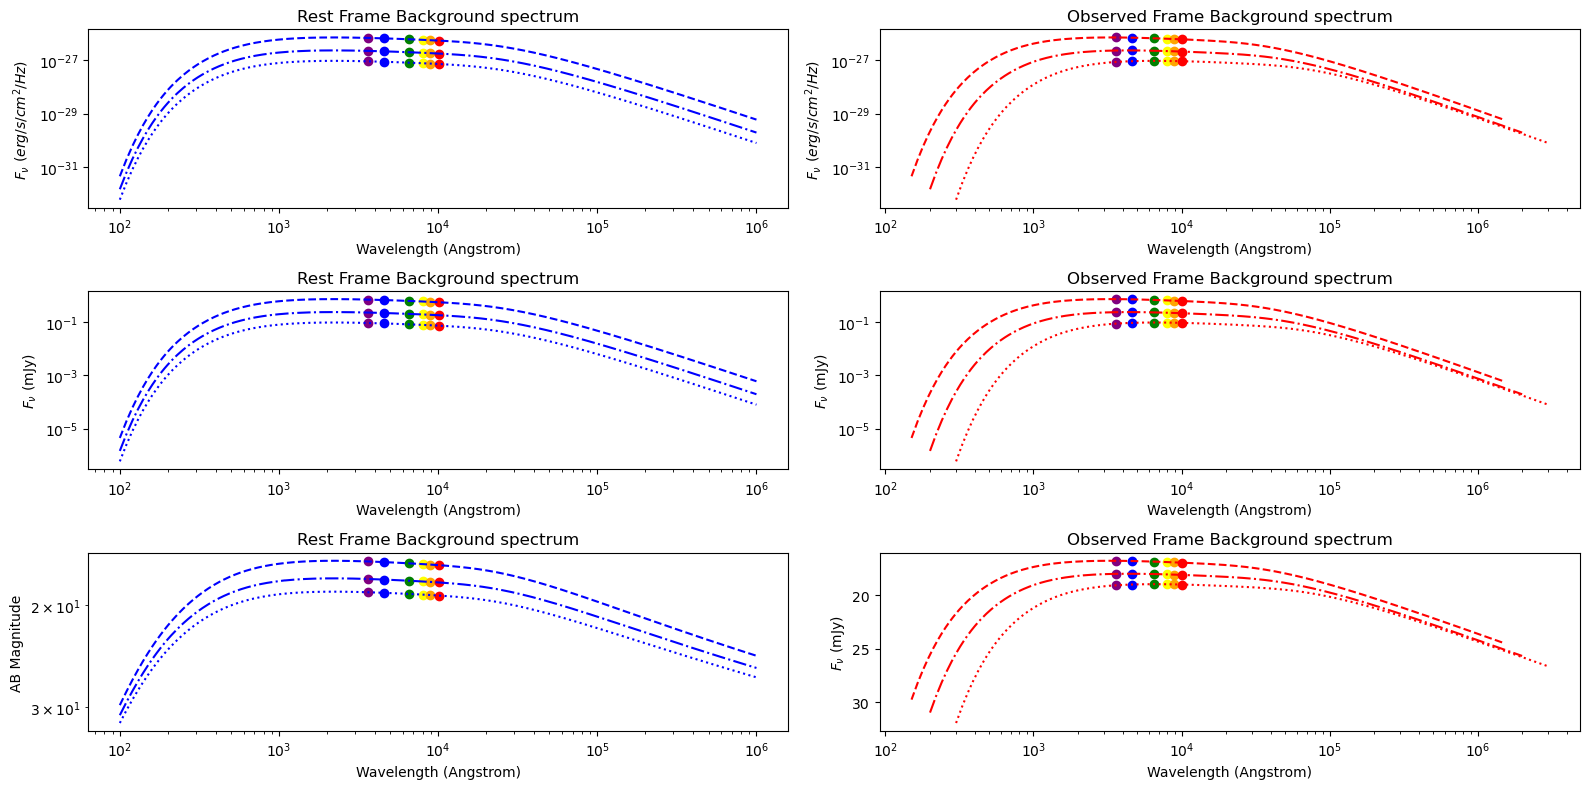

[231, 297, 425, 522, 584, 664] [171, 220, 316, 389, 436, 495] [110, 142, 205, 254, 284, 324]


In [12]:
colors = ['purple','blue','green','yellow','orange','red'] 
background_L_z05 = []
background_index_z05 = []

background_L_z1 = []
background_index_z1 = []

background_L_z2 = []
background_index_z2 = []

F_nu2mJy = 1e+26

for wav in wavref:
    index = np.where((wavelengths >= 0.99*(wav*1e-10)) & (wavelengths <= 1.01*(wav*1e-10)))[0]
    background_L_z05.append(emitted_spectrum_z05[index][0])
    background_index_z05.append(index[0])
    background_L_z1.append(emitted_spectrum_z1[index][0])
    background_index_z1.append(index[0])
    background_L_z2.append(emitted_spectrum_z2[index][0])
    background_index_z2.append(index[0])


    #print(wav, emitted_spectrum[index][0])
# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(16, 8))
axs[0,0].plot(wavelengths * 1e+10, emitted_spectrum_z05, color='blue', label='z=0.5', linestyle='--')
axs[0,0].plot(wavelengths * 1e+10, emitted_spectrum_z1, color='blue', label='z=1', linestyle='-.')
axs[0,0].plot(wavelengths * 1e+10, emitted_spectrum_z2, color='blue', label='z=2', linestyle=':')
axs[0,0].set_yscale('log')
axs[0,0].set_xscale('log')
axs[0,0].set_xlabel('Wavelength (Angstrom)')
axs[0,0].set_ylabel(r'$F_\nu$ ($erg/s/cm^2/Hz$)')
axs[0,0].set_title('Rest Frame Background spectrum')

for i in range(len(background_index_z05)):
    axs[0,0].scatter(wavelengths[background_index_z05[i]]*1e+10, background_L_z05[i], color=colors[i])
    axs[0,0].scatter(wavelengths[background_index_z1[i]]*1e+10, background_L_z1[i], color=colors[i])
    axs[0,0].scatter(wavelengths[background_index_z2[i]]*1e+10, background_L_z2[i], color=colors[i])


axs[1,0].plot(wavelengths * 1e+10, F_nu2mJy*emitted_spectrum_z05, color='blue', label='z=0.5', linestyle='--')
axs[1,0].plot(wavelengths * 1e+10, F_nu2mJy*emitted_spectrum_z1, color='blue', label='z=1', linestyle='-.')
axs[1,0].plot(wavelengths * 1e+10, F_nu2mJy*emitted_spectrum_z2, color='blue', label='z=2', linestyle=':')
axs[1,0].set_yscale('log')
axs[1,0].set_xscale('log')
axs[1,0].set_xlabel('Wavelength (Angstrom)')
axs[1,0].set_ylabel(r'$F_\nu$ (mJy)')
axs[1,0].set_title('Rest Frame Background spectrum')

for i in range(len(background_index_z05)):
    axs[1,0].scatter(wavelengths[background_index_z05[i]]*1e+10, F_nu2mJy*background_L_z05[i], color=colors[i])
    axs[1,0].scatter(wavelengths[background_index_z1[i]]*1e+10, F_nu2mJy*background_L_z1[i], color=colors[i])
    axs[1,0].scatter(wavelengths[background_index_z2[i]]*1e+10, F_nu2mJy*background_L_z2[i], color=colors[i])

axs[2,0].plot(wavelengths * 1e+10, fnu_to_abmag(emitted_spectrum_z05), color='blue', label='z=0.5', linestyle='--')
axs[2,0].plot(wavelengths * 1e+10, fnu_to_abmag(emitted_spectrum_z1), color='blue', label='z=1', linestyle='-.')
axs[2,0].plot(wavelengths * 1e+10, fnu_to_abmag(emitted_spectrum_z2), color='blue', label='z=2', linestyle=':')
axs[2,0].set_yscale('log')
axs[2,0].set_xscale('log')
axs[2,0].set_xlabel('Wavelength (Angstrom)')
axs[2,0].set_ylabel('AB Magnitude')
axs[2,0].set_title('Rest Frame Background spectrum')
axs[2,0].invert_yaxis()

for i in range(len(background_index_z05)):
    axs[2,0].scatter(wavelengths[background_index_z05[i]]*1e+10, fnu_to_abmag(background_L_z05[i]), color=colors[i])
    axs[2,0].scatter(wavelengths[background_index_z1[i]]*1e+10, fnu_to_abmag(background_L_z1[i]), color=colors[i])
    axs[2,0].scatter(wavelengths[background_index_z2[i]]*1e+10, fnu_to_abmag(background_L_z2[i]), color=colors[i])

redshifted_wavelength_z05 = wavelengths * (1 + 0.5)
redshifted_wavelength_z1 = wavelengths * (1 + 1)
redshifted_wavelength_z2 = wavelengths * (1 + 2)
rs_background_L_z05 = []
rs_background_index_z05 = []

rs_background_L_z1 = []
rs_background_index_z1 = []

rs_background_L_z2 = []
rs_background_index_z2 = []

for wav in wavref:
    index = np.where((redshifted_wavelength_z05 >= 0.99*(wav*1e-10)) & (redshifted_wavelength_z05 <= 1.01*(wav*1e-10)))[0]
    rs_background_L_z05.append(emitted_spectrum_z05[index][0])
    rs_background_index_z05.append(index[0])

for wav in wavref:
    index = np.where((redshifted_wavelength_z1 >= 0.99*(wav*1e-10)) & (redshifted_wavelength_z1 <= 1.01*(wav*1e-10)))[0]
    rs_background_L_z1.append(emitted_spectrum_z1[index][0])
    rs_background_index_z1.append(index[0])

for wav in wavref:
    index = np.where((redshifted_wavelength_z2 >= 0.98*(wav*1e-10)) & (redshifted_wavelength_z2 <= 1.01*(wav*1e-10)))[0]
    rs_background_L_z2.append(emitted_spectrum_z2[index][0])
    rs_background_index_z2.append(index[0])

# Create subplots
axs[0,1].plot(redshifted_wavelength_z05 * 1e+10, emitted_spectrum_z05, color='red', label='z=0.5', linestyle='--')
axs[0,1].plot(redshifted_wavelength_z1 * 1e+10, emitted_spectrum_z1, color='red', label='z=1', linestyle='-.')
axs[0,1].plot(redshifted_wavelength_z2 * 1e+10, emitted_spectrum_z2, color='red', label='z=2', linestyle=':')
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
axs[0,1].set_xlabel('Wavelength (Angstrom)')
axs[0,1].set_ylabel(r'$F_\nu$ ($erg/s/cm^2/Hz$)')
axs[0,1].set_title('Observed Frame Background spectrum')

for i in range(len(background_index_z05)):
    axs[0,1].scatter(wavelengths[background_index_z05[i]]*1e+10, rs_background_L_z05[i], color=colors[i])
    axs[0,1].scatter(wavelengths[background_index_z1[i]]*1e+10, rs_background_L_z1[i], color=colors[i])
    axs[0,1].scatter(wavelengths[background_index_z2[i]]*1e+10, rs_background_L_z2[i], color=colors[i])



axs[1,1].plot(redshifted_wavelength_z05 * 1e+10, F_nu2mJy*emitted_spectrum_z05, color='red', label='z=0.5', linestyle='--')
axs[1,1].plot(redshifted_wavelength_z1 * 1e+10, F_nu2mJy*emitted_spectrum_z1, color='red', label='z=1', linestyle='-.')
axs[1,1].plot(redshifted_wavelength_z2 * 1e+10, F_nu2mJy*emitted_spectrum_z2, color='red', label='z=2', linestyle=':')
axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[1,1].set_xlabel('Wavelength (Angstrom)')
axs[1,1].set_ylabel(r'$F_\nu$ (mJy)')
axs[1,1].set_title('Observed Frame Background spectrum')

for i in range(len(background_index_z05)):
    axs[1,1].scatter(wavelengths[background_index_z05[i]]*1e+10, F_nu2mJy*rs_background_L_z05[i], color=colors[i])
    axs[1,1].scatter(wavelengths[background_index_z1[i]]*1e+10, F_nu2mJy*rs_background_L_z1[i], color=colors[i])
    axs[1,1].scatter(wavelengths[background_index_z2[i]]*1e+10, F_nu2mJy*rs_background_L_z2[i], color=colors[i])

axs[2,1].plot(redshifted_wavelength_z05 * 1e+10, fnu_to_abmag(emitted_spectrum_z05), color='red', label='z=0.5', linestyle='--')
axs[2,1].plot(redshifted_wavelength_z1 * 1e+10, fnu_to_abmag(emitted_spectrum_z1), color='red', label='z=1', linestyle='-.')
axs[2,1].plot(redshifted_wavelength_z2 * 1e+10, fnu_to_abmag(emitted_spectrum_z2), color='red', label='z=2', linestyle=':')
axs[2,1].set_xscale('log')
axs[2,1].set_xlabel('Wavelength (Angstrom)')
axs[2,1].set_ylabel(r'$F_\nu$ (mJy)')
axs[2,1].set_title('Observed Frame Background spectrum')
axs[2,1].invert_yaxis()

for i in range(len(background_index_z05)):
    axs[2,1].scatter(wavelengths[background_index_z05[i]]*1e+10, fnu_to_abmag(rs_background_L_z05[i]), color=colors[i])
    axs[2,1].scatter(wavelengths[background_index_z1[i]]*1e+10, fnu_to_abmag(rs_background_L_z1[i]), color=colors[i])
    axs[2,1].scatter(wavelengths[background_index_z2[i]]*1e+10, fnu_to_abmag(rs_background_L_z2[i]), color=colors[i])

plt.tight_layout()
plt.show()
print(rs_background_index_z05,rs_background_index_z1,rs_background_index_z2)



## AGN Reddening

### SMC Bar Extinction

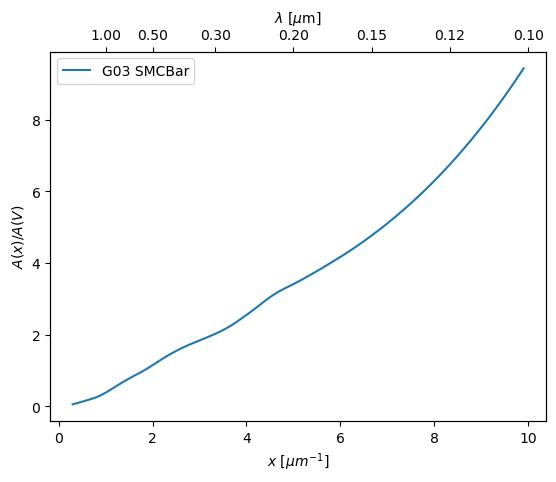

In [13]:
fig, ax = plt.subplots()
# define the extinction model
ext_model = G03_SMCBar()
# generate the curves and plot them
x = np.arange(ext_model.x_range[0], ext_model.x_range[1],0.1)/u.micron
ax.plot(x,ext_model(x),label='G03 SMCBar')
#print(x)
lamb = (1/(x)).to(u.AA)
#print(lamb)
#ax.plot(lamb,ext_model(x),label='G03 SMCBar')

ax.set_xlabel(r'$x$ [$\mu m^{-1}$]')
ax.set_ylabel(r'$A(x)/A(V)$')

# for 2nd x-axis with lambda values
axis_xs = np.array([0.1, 0.12, 0.15, 0.2, 0.3, 0.5, 1.0])
new_ticks = 1 / axis_xs
new_ticks_labels = ["%.2f" % z for z in axis_xs]
tax = ax.twiny()
tax.set_xlim(ax.get_xlim())
tax.set_xticks(new_ticks)
tax.set_xticklabels(new_ticks_labels)
tax.set_xlabel(r"$\lambda$ [$\mu$m]")

ax.legend(loc='best')
plt.show()

3230
[17.87669342 17.60149915 17.41786494 17.31802281 17.28431627 17.25756173]
[19.54953105 19.17232363 18.78071723 18.67834265 18.61850367 18.55438948]
[21.79725612 20.88226358 20.24184862 19.92277284 19.81482204 19.73974382]


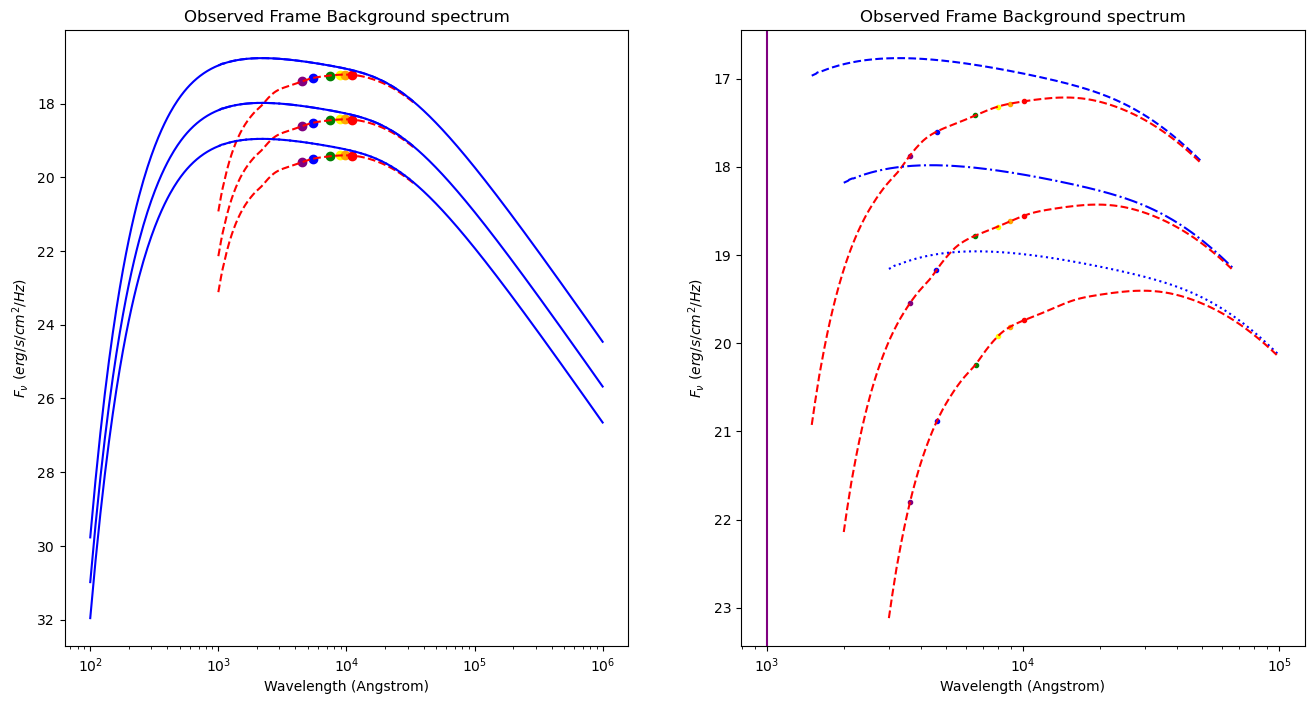

In [14]:
# Example usage
ebv = 0.15  # Color excess E(B-V)
wavref = [3650,4640,6580,8060,9000,10200]

# Filter wavelengths to be within the valid range for G03_SMCBar
valid_range = (wavelengths >= 0.1e-6) & (wavelengths <= 3.33e-6)
filtered_wavelengths = wavelengths[valid_range] *u.m
filtered_emitted_spectrum_z05 = emitted_spectrum_z05[valid_range]
filtered_emitted_spectrum_z1 = emitted_spectrum_z1[valid_range]
filtered_emitted_spectrum_z2 = emitted_spectrum_z2[valid_range]
# Compute the extinction curve
print(len(filtered_wavelengths))
spectrum_ext_z05 = filtered_emitted_spectrum_z05 * ext_model.extinguish(filtered_wavelengths, Ebv=0.15)
spectrum_ext_z1 = filtered_emitted_spectrum_z1 * ext_model.extinguish(filtered_wavelengths, Ebv=0.15)
spectrum_ext_z2 = filtered_emitted_spectrum_z2 * ext_model.extinguish(filtered_wavelengths, Ebv=0.15)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].plot(filtered_wavelengths * 1e+10, fnu_to_abmag(filtered_emitted_spectrum_z05), color='blue',linestyle='--', label='Spectrum')
axs[0].plot(filtered_wavelengths * 1e+10, fnu_to_abmag(spectrum_ext_z05), color='red', linestyle='--', label='Redden')
axs[0].plot(filtered_wavelengths * 1e+10, fnu_to_abmag(filtered_emitted_spectrum_z1), color='blue',linestyle='-.', label='Spectrum')
axs[0].plot(filtered_wavelengths * 1e+10, fnu_to_abmag(spectrum_ext_z1), color='red', linestyle='--', label='Redden')
axs[0].plot(filtered_wavelengths * 1e+10, fnu_to_abmag(filtered_emitted_spectrum_z2), color='blue',linestyle=':', label='Spectrum')
axs[0].plot(filtered_wavelengths * 1e+10, fnu_to_abmag(spectrum_ext_z2), color='red', linestyle='--', label='Redden')
axs[0].plot(wavelengths * 1e+10, fnu_to_abmag(emitted_spectrum_z2), color='blue')
axs[0].plot(wavelengths * 1e+10, fnu_to_abmag(emitted_spectrum_z1), color='blue')
axs[0].plot(wavelengths * 1e+10, fnu_to_abmag(emitted_spectrum_z05), color='blue')

axs[1].plot(filtered_wavelengths*(1+0.5) * 1e+10, fnu_to_abmag(filtered_emitted_spectrum_z05), color='blue',linestyle='--', label='Spectrum')
axs[1].plot(filtered_wavelengths*(1+0.5) * 1e+10, fnu_to_abmag(spectrum_ext_z05), color='red', linestyle='--', label='Redden')
axs[1].plot(filtered_wavelengths*(1+1) * 1e+10, fnu_to_abmag(filtered_emitted_spectrum_z1), color='blue',linestyle='-.', label='Spectrum')
axs[1].plot(filtered_wavelengths*(1+1) * 1e+10, fnu_to_abmag(spectrum_ext_z1), color='red', linestyle='--', label='Redden')
axs[1].plot(filtered_wavelengths*(1+2) * 1e+10, fnu_to_abmag(filtered_emitted_spectrum_z2), color='blue',linestyle=':', label='Spectrum')
axs[1].plot(filtered_wavelengths*(1+2) * 1e+10, fnu_to_abmag(spectrum_ext_z2), color='red', linestyle='--', label='Redden')
#axs[1].plot(wavelengths * 1e+10, fnu_to_abmag(emitted_spectrum_z2), color='red')
#axs[1].plot(wavelengths * 1e+10, fnu_to_abmag(emitted_spectrum_z1), color='red')
#axs[1].plot(wavelengths * 1e+10, fnu_to_abmag(emitted_spectrum_z05), color='red')
#axs[0].legend()

axs[0].invert_yaxis()
axs[0].set_xscale('log')
axs[0].set_xlabel('Wavelength (Angstrom)')
axs[0].set_ylabel(r'$F_\nu$ ($erg/s/cm^2/Hz$)')
axs[0].set_title('Observed Frame Background spectrum')

# Redshifted wavelengths    
# WE EXTINCT IN THE REST FRAME THEN REDSHIFT

'''
valid_range_z05 = (redshifted_wavelength_z05 >= 0.1e-6) & (redshifted_wavelength_z05 <= 3.33e-6)
valid_range_z1 = (redshifted_wavelength_z1 >= 0.1e-6) & (redshifted_wavelength_z1 <= 3.33e-6)
valid_range_z2 = (redshifted_wavelength_z2 >= 0.1e-6) & (redshifted_wavelength_z2 <= 3.33e-6)

filtered_wavelengths = wavelengths[valid_range] *u.m
filtered_wavelengths_z05 = redshifted_wavelength_z05[valid_range_z05] *u.m
filtered_wavelengths_z1 = redshifted_wavelength_z1[valid_range_z1] *u.m
filtered_wavelengths_z2 = redshifted_wavelength_z2[valid_range_z2] *u.m

filtered_emitted_spectrum_z05 = emitted_spectrum_z05[valid_range_z05]
filtered_emitted_spectrum_z1 = emitted_spectrum_z1[valid_range_z1]
filtered_emitted_spectrum_z2 = emitted_spectrum_z2[valid_range_z2]

redshifted_spectrum_ext_z05 = filtered_emitted_spectrum_z05 * ext_model.extinguish(filtered_wavelengths_z05, Ebv=0.15)
redshifted_spectrum_ext_z1 = filtered_emitted_spectrum_z1 * ext_model.extinguish(filtered_wavelengths_z1, Ebv=0.15)
redshifted_spectrum_ext_z2 = filtered_emitted_spectrum_z2 * ext_model.extinguish(filtered_wavelengths_z2, Ebv=0.15)
'''

redshifted_wavelength_z05 = wavelengths[valid_range] * (1 + 0.5)
redshifted_wavelength_z1 = wavelengths[valid_range] * (1 + 1)
redshifted_wavelength_z2 = wavelengths[valid_range] * (1 + 2)

background_L_ext_z05 = []
background_L_ext_z1 = []
background_L_ext_z2 = []
background_index_ext_z05 = []
background_index_ext_z1 = []
background_index_ext_z2 = []

for wav in wavref:
    # Find the index of filter lamb in the OBS frame, index equivalent to the rest frame
    index = np.where((redshifted_wavelength_z05 >= 0.99*(wav*1e-10)))[0] #& (redshifted_wavelength_z05[valid_range_z05] <= 1.01*(wav*1e-10)))[0]
    # Find brightness at the index
    background_L_ext_z05.append(spectrum_ext_z05[index][0])
    background_index_ext_z05.append(index[0])

for wav in wavref:
    index = np.where((redshifted_wavelength_z1 >= 0.99*(wav*1e-10)))[0] # & (redshifted_wavelength_z1[valid_range_z1] <= 1.01*(wav*1e-10)))[0]
    background_L_ext_z1.append(spectrum_ext_z1[index][0])
    background_index_ext_z1.append(index[0])

for wav in wavref:
    index = np.where((redshifted_wavelength_z2 >= 0.99*(wav*1e-10)))[0] # & (redshifted_wavelength_z2[valid_range_z2] <= 1.01*(wav*1e-10)))[0]
    background_L_ext_z2.append(spectrum_ext_z2[index][0])
    background_index_ext_z2.append(index[0])

#axs[1].plot(redshifted_wavelength_z05 * 1e+10, fnu_to_abmag(emitted_spectrum_z05), color='blue')
#axs[1].plot(redshifted_wavelength_z1 * 1e+10, fnu_to_abmag(emitted_spectrum_z1), color='blue')
#axs[1].plot(redshifted_wavelength_z2 * 1e+10, fnu_to_abmag(emitted_spectrum_z2), color='blue')
axs[1].axvline(1000, color='purple')
"""
axs[1].plot(redshifted_wavelength_z05[valid_range_z05] * 1e+10, fnu_to_abmag(filtered_emitted_spectrum_z05), color='blue',linestyle='--', label='Spectrum')
axs[1].plot(redshifted_wavelength_z05[valid_range_z05] * 1e+10, fnu_to_abmag(redshifted_spectrum_ext_z05), color='red', linestyle='--', label='Redden')
axs[1].plot(redshifted_wavelength_z1[valid_range_z1] * 1e+10, fnu_to_abmag(filtered_emitted_spectrum_z1), color='blue',linestyle='-.', label='Spectrum')
axs[1].plot(redshifted_wavelength_z1[valid_range_z1] * 1e+10, fnu_to_abmag(redshifted_spectrum_ext_z1), color='red', linestyle='--', label='Redden')
axs[1].plot(redshifted_wavelength_z2[valid_range_z2] * 1e+10, fnu_to_abmag(filtered_emitted_spectrum_z2), color='blue',linestyle=':', label='Spectrum')
axs[1].plot(redshifted_wavelength_z2[valid_range_z2] * 1e+10, fnu_to_abmag(redshifted_spectrum_ext_z2), color='red', linestyle='--', label='Redden')
"""
axs[1].invert_yaxis()
axs[1].set_xscale('log')
axs[1].set_xlabel('Wavelength (Angstrom)')
axs[1].set_ylabel(r'$F_\nu$ ($erg/s/cm^2/Hz$)')
axs[1].set_title('Observed Frame Background spectrum')
#axs[1].set_xlim(1e3,3e4)
for i in range(len(background_index_z05)):
    #axs[1].scatter(wavelengths[background_index_z05[i]]*1e+10, fnu_to_abmag(rs_background_L_z05[i]), color=colors[i])
    #axs[1].scatter(wavelengths[background_index_z1[i]]*1e+10, fnu_to_abmag(rs_background_L_z1[i]), color=colors[i])
    #axs[1].scatter(wavelengths[background_index_z2[i]]*1e+10, fnu_to_abmag(rs_background_L_z2[i]), color=colors[i])
    axs[0].scatter(filtered_wavelengths[background_index_z05[i]]*1e+10, fnu_to_abmag(spectrum_ext_z05[background_index_z05][i]), color=colors[i])
    axs[0].scatter(filtered_wavelengths[background_index_z1[i]]*1e+10, fnu_to_abmag(spectrum_ext_z1[background_index_z05][i]), color=colors[i])
    axs[0].scatter(filtered_wavelengths[background_index_z2[i]]*1e+10, fnu_to_abmag(spectrum_ext_z2[background_index_z05][i]), color=colors[i])

    axs[1].scatter(redshifted_wavelength_z05[background_index_ext_z05[i]]*1e+10, fnu_to_abmag(background_L_ext_z05[i]), color=colors[i],marker='.')
    axs[1].scatter(redshifted_wavelength_z1[background_index_ext_z1[i]]*1e+10, fnu_to_abmag(background_L_ext_z1[i]), color=colors[i],marker='.')
    axs[1].scatter(redshifted_wavelength_z2[background_index_ext_z2[i]]*1e+10, fnu_to_abmag(background_L_ext_z2[i]), color=colors[i],marker='.')
print(fnu_to_abmag(background_L_ext_z05))
print(fnu_to_abmag(background_L_ext_z1))
print(fnu_to_abmag(background_L_ext_z2))



## Transfer Function and Light Curve

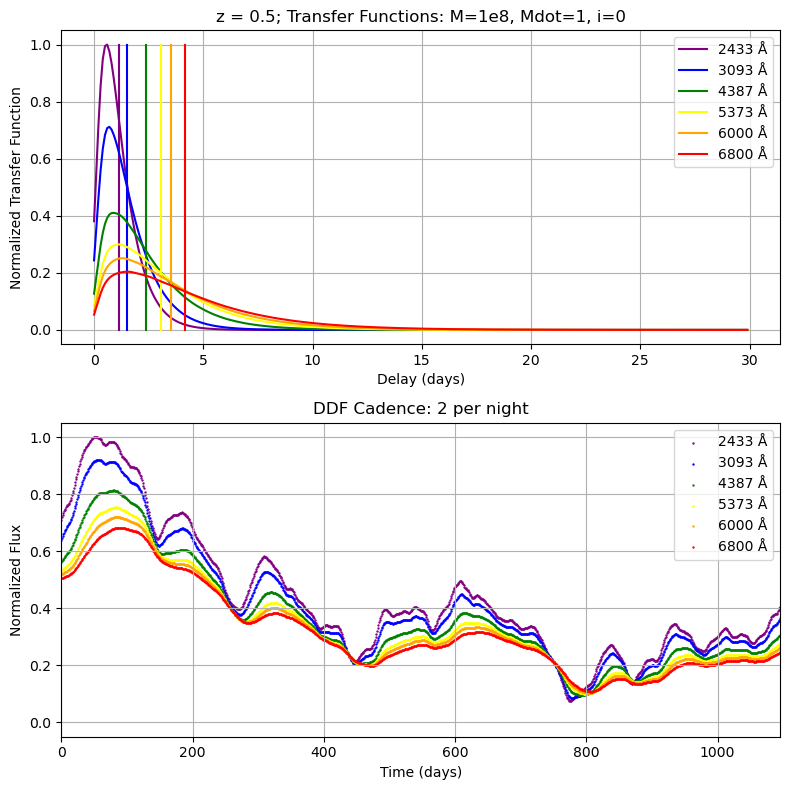

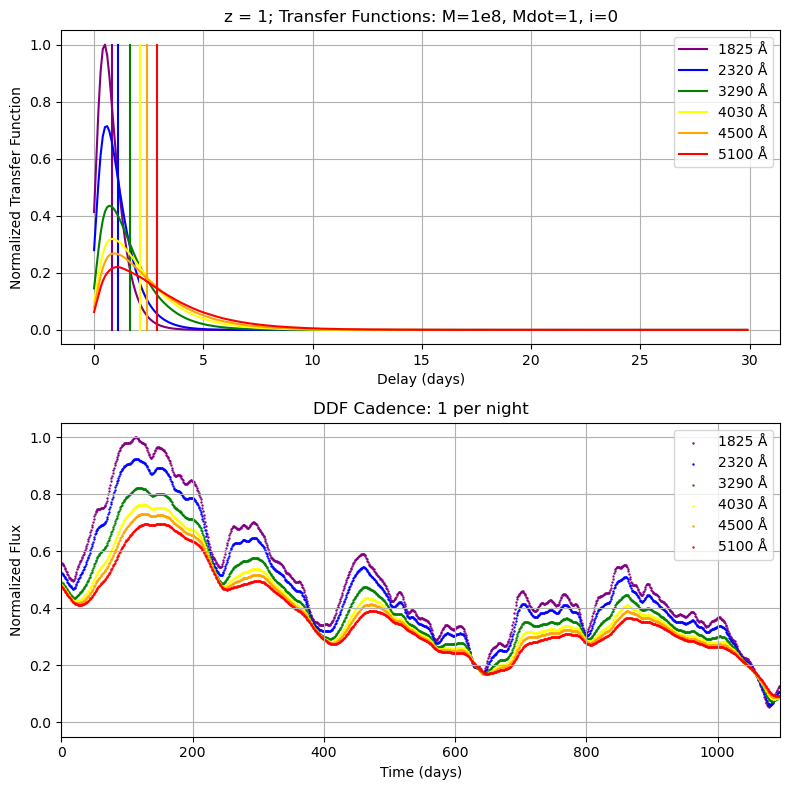

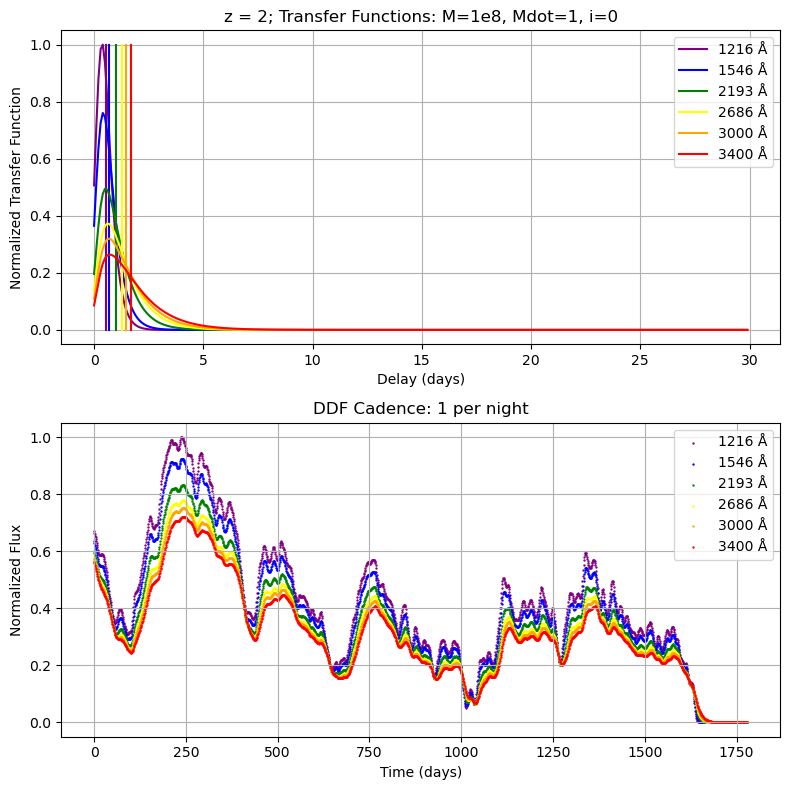

In [25]:
# Define the list of wavelengths
wavref = [3650,4640,6580,8060,9000,10200]
redshift_wav05 = [2433, 3093, 4387, 5373, 6000, 6800]
redshift_wav1 = [1825, 2320, 3290, 4030, 4500, 5100]
redshift_wav2 = [1216, 1546, 2193, 2686, 3000, 3400]
mean_delay = []
#color=['r','b','cyan','purple','orange','green','skyplue','magenta']
color = ['purple','blue','green','yellow','orange','red']   
cadence = 10
normalised_lc_rest = (light_curve_rest - min(light_curve_rest))/(max(light_curve_rest)-min(light_curve_rest))
normalised_lc_z05 = (light_curve_z05 - min(light_curve_z05))/(max(light_curve_z05)-min(light_curve_z05))
normalised_lc_z1 = (light_curve_z1 - min(light_curve_z1))/(max(light_curve_z1)-min(light_curve_z1))
normalised_lc_z2 = (light_curve_z2 - min(light_curve_z2))/(max(light_curve_z2)-min(light_curve_z2))

normalised_interpt_lc_z2 = normalise(interpolated_lc_z2)
normalised_interpt_lc_z1 = normalise(interpolated_lc_z1)[0:365*4]
normalised_interpt_lc_z05 = normalise(interpolated_lc_z05)[0:365*4]
days_interp_4 = days_interp[0:365*4]
######################################################################################################
# z = 0.5
# Plotting the transfer functions and convolved light curves
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
# Plot the original light curve
#axs[1].scatter(days, normalised_lc, s=0.5, color='blue', label='Original Light Curve')
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Normalised Flux')
wav_list = redshift_wav05
for i, wav in enumerate(wav_list):
    filename = 'Data/Fiducial/z05/' +str(wav)+'_transfer_function.csv'
    #filename = str(wav)+'_transfer_function.csv'
    df = pd.read_csv(filename)

    if wav == wav_list[0]:
        max_val = df['psis'].max()
        min_val = df['psis'].min()
        normalized_psis = (df['psis'] - min_val) / max_val
        convolved_light_curve = convolve(normalised_interpt_lc_z05, normalized_psis, mode='same', method='direct')
        max_con = max(convolved_light_curve)
        min_con = min(convolved_light_curve)

    mean = np.sum(df['taus']*df['psis'])/np.sum(df['psis'])
    mean_delay.append(mean)
    normalized_psis = (df['psis'] - min_val) / max_val

    convolved_light_curve = convolve(normalised_interpt_lc_z05, normalized_psis, mode='same', method='direct')
    #print('z05: ',len(convolved_light_curve))
    normalize_convolved_light_curve = (convolved_light_curve-min_con)/(max_con-min_con)
    errors = abs(np.random.normal(0, 0.05, size=len(normalize_convolved_light_curve)))
    # Normalize the convolved light curve
    
    # Plot the normalized transfer function
    axs[0].plot(df['taus'], normalized_psis,color=color[i], label=f'{int(wav)} Å')
    axs[0].plot([mean,mean],[0.0,1.0],color=color[i],label=None)
    
    # Plot the convolved light curve
    axs[1].scatter(days_interp_4, normalize_convolved_light_curve,s=0.5,color=color[i], label=f'{int(wav)} Å')
    #axs[2].scatter(days[::4]*(1+0.5), normalize_convolved_light_curve[::4],s=0.5,color=color[i], label=f'{int(wav)} Å')

    with open( 'Data/Fiducial/z05/' +str(wav)+'_light_curve.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['time', 'normalised_flux [arbitary unit]','error'])  # Write the header
        for tau, flux, error  in zip(days, normalize_convolved_light_curve, errors):
            csvwriter.writerow([tau, flux, error])

axs[0].set_xlabel('Delay (days)')
axs[0].set_ylabel('Normalized Transfer Function')
axs[0].set_title('z = 0.5; Transfer Functions: M=1e8, Mdot=1, i=0')
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Normalized Flux')
axs[1].set_title('DDF Cadence: 2 per night')
axs[1].legend()
axs[1].grid()
axs[1].set_xlim(0, 3*365)
#axs[1].set_xlim(0, 12)
plt.tight_layout()
plt.show()

######################################################################################################
# z = 1
# Plotting the transfer functions and convolved light curves
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
# Plot the original light curve
#axs[1].scatter(days, normalised_lc, s=0.5, color='blue', label='Original Light Curve')
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Normalised Flux')
wav_list = redshift_wav1
for i, wav in enumerate(wav_list):
    filename = 'Data/Fiducial/z1/' +str(wav)+'_transfer_function.csv'
    #filename = str(wav)+'_transfer_function.csv'
    df = pd.read_csv(filename)

    if wav == wav_list[0]:
        max_val = df['psis'].max()
        min_val = df['psis'].min()
        normalized_psis = (df['psis'] - min_val) / max_val
        convolved_light_curve = convolve(normalised_interpt_lc_z1, normalized_psis, mode='same', method='direct')
        max_con = max(convolved_light_curve)
        min_con = min(convolved_light_curve)

    mean = np.sum(df['taus']*df['psis'])/np.sum(df['psis'])
    mean_delay.append(mean)
    normalized_psis = (df['psis'] - min_val) / max_val

    convolved_light_curve = convolve(normalised_interpt_lc_z1, normalized_psis, mode='same', method='direct')
    #print('z05: ',len(convolved_light_curve))
    normalize_convolved_light_curve = (convolved_light_curve-min_con)/(max_con-min_con)
    errors = abs(np.random.normal(0, 0.05, size=len(normalize_convolved_light_curve)))
    # Normalize the convolved light curve
    
    # Plot the normalized transfer function
    axs[0].plot(df['taus'], normalized_psis,color=color[i], label=f'{int(wav)} Å')
    axs[0].plot([mean,mean],[0.0,1.0],color=color[i],label=None)
    
    # Plot the convolved light curve
    axs[1].scatter(days_interp_4, normalize_convolved_light_curve,s=0.5,color=color[i], label=f'{int(wav)} Å')

    with open( 'Data/Fiducial/z1/' +str(wav)+'_light_curve.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['time', 'normalised_flux [arbitary unit]','error'])  # Write the header
        for tau, flux, error  in zip(days, normalize_convolved_light_curve, errors):
            csvwriter.writerow([tau, flux, error])

axs[0].set_xlabel('Delay (days)')
axs[0].set_ylabel('Normalized Transfer Function')
axs[0].set_title('z = 1; Transfer Functions: M=1e8, Mdot=1, i=0')
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Normalized Flux')
axs[1].set_title('DDF Cadence: 1 per night')
axs[1].legend()
axs[1].grid()
axs[1].set_xlim(0, 3*365)
#axs[1].set_xlim(0, 12)
plt.tight_layout()
plt.show()

######################################################################################################
# z = 2
# Plotting the transfer functions and convolved light curves
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
# Plot the original light curve
#axs[1].scatter(days, normalised_lc, s=0.5, color='blue', label='Original Light Curve')
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Normalised Flux')
wav_list = redshift_wav2
for i, wav in enumerate(wav_list):
    filename = 'Data/Fiducial/z2/' +str(wav)+'_transfer_function.csv'
    #filename = str(wav)+'_transfer_function.csv'
    df = pd.read_csv(filename)

    if wav == wav_list[0]:
        max_val = df['psis'].max()
        min_val = df['psis'].min()
        normalized_psis = (df['psis'] - min_val) / max_val
        convolved_light_curve = convolve(normalised_interpt_lc_z2, normalized_psis, mode='same', method='direct')
        max_con = max(convolved_light_curve)
        min_con = min(convolved_light_curve)

    mean = np.sum(df['taus']*df['psis'])/np.sum(df['psis'])
    mean_delay.append(mean)
    normalized_psis = (df['psis'] - min_val) / max_val

    convolved_light_curve = convolve(normalised_interpt_lc_z2, normalized_psis, mode='same', method='direct')
    normalize_convolved_light_curve = (convolved_light_curve-min_con)/(max_con-min_con)
    errors = abs(np.random.normal(0, 0.05, size=len(normalize_convolved_light_curve)))
    # Normalize the convolved light curve
    
    # Plot the normalized transfer function
    axs[0].plot(df['taus'], normalized_psis,color=color[i], label=f'{int(wav)} Å')
    axs[0].plot([mean,mean],[0.0,1.0],color=color[i],label=None)
    #print(len(days_interp),len(normalize_convolved_light_curve))
    # Plot the convolved light curve
    axs[1].scatter(days_interp, normalize_convolved_light_curve,s=0.5,color=color[i], label=f'{int(wav)} Å')

    with open( 'Data/Fiducial/z2/' +str(wav)+'_light_curve.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['time', 'normalised_flux [arbitary unit]','error'])  # Write the header
        for tau, flux, error  in zip(days[:1460], normalize_convolved_light_curve[:1460], errors):
            csvwriter.writerow([tau, flux, error])

axs[0].set_xlabel('Delay (days)')
axs[0].set_ylabel('Normalized Transfer Function')
axs[0].set_title('z = 2; Transfer Functions: M=1e8, Mdot=1, i=0')
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Normalized Flux')
axs[1].set_title('DDF Cadence: 1 per night')
axs[1].legend()
axs[1].grid()


plt.tight_layout()
plt.show()

### Scaled Light Curve with Background

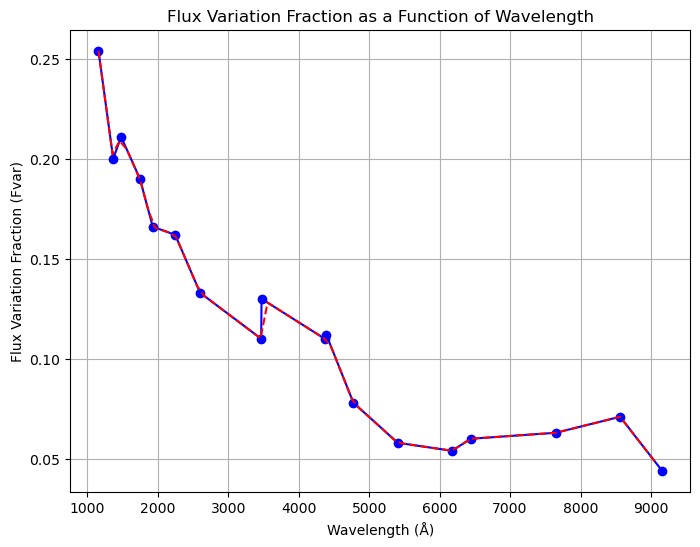

In [32]:
# Extracted data from Table 5 (approximate values)
wavelengths = [1158, 1367.0, 1479, 1746.0,1928, 2246, 2600,3467,3472,4369,4392,4776,5404,6176,6440,7648,8561,9157]
flux_variation_fraction = [0.254,0.2,0.211,0.19,0.166,0.162,0.133,0.110,0.13,0.11,0.112,0.078,0.058,0.054,0.060,0.063,0.071,0.044]  # Estimated from Table 5
interpolated_flux_variation_fraction = interp1d(wavelengths, flux_variation_fraction)
interp_fvf = interpolated_flux_variation_fraction(np.arange(1158,9157.0,100))
# Create DataFrame for visualization
df = pd.DataFrame({"Wavelength (Å)": wavelengths, "Flux Variation Fraction": flux_variation_fraction})

# Plot the flux variation fraction as a function of wavelength
plt.figure(figsize=(8, 6))
plt.plot(df["Wavelength (Å)"], df["Flux Variation Fraction"], marker='o', linestyle='-', color='b')
plt.plot(np.arange(1157.5,9157.0,100), interp_fvf, linestyle='--', color='r')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux Variation Fraction (Fvar)")
plt.title("Flux Variation Fraction as a Function of Wavelength")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

# Define the polynomial function to fit
def poly_func(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Extract the data
wavelengths = np.array([1158, 1367.0, 1479, 1746.0, 1928, 2246, 2600, 3467, 3472, 4369, 4392, 4776, 5404, 6176, 6440, 7648, 8561, 9157])
flux_variation_fraction = np.array([0.254, 0.2, 0.211, 0.19, 0.166, 0.162, 0.133, 0.11, 0.13, 0.11, 0.112, 0.078, 0.058, 0.054, 0.06, 0.063, 0.071, 0.044])

# Fit the polynomial function to the data
popt, pcov = curve_fit(poly_func, wavelengths, flux_variation_fraction)

# Generate fitted values
fitted_values = poly_func(wavelengths, *popt)

# Plot the original data and the fitted function
plt.figure(figsize=(8, 6))
plt.plot(wavelengths, flux_variation_fraction, 'o', label='Original Data')
plt.plot(wavelengths, fitted_values, '-', label='Fitted Function')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux Variation Fraction')
plt.title('Polynomial Fit to Flux Variation Fraction')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
scaled_light_curves_z05 = []
scaled_light_curves_z1 = []
scaled_light_curves_z2 = []

#UGRIZY
wavref_fvf_rest = [[3650,0.13],[4640,0.078],[6580,0.06],[8060,0.071],[9000,0.044],[10200,0.03]]
wavref_fvf_z05 = [[2433,0.095], [3093,0.08], [4387,0.06], [5373,0.058], [6000,0.038], [6800,0.035]]
wavref_fvf_z1 = [[1825,0.138], [2320,0.1], [3290,0.07], [4030,0.0625], [4500,0.055], 5100]]
wavref_fvf_z2 = [[1216, 1546, 2193, 2686, 3000, 3400]]
wav_list = wavref_fvf_z05
fvf = []
##############################################################################################################
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
for i, wav in enumerate(wav_list):
    # Calculate the mean and standard deviation of the convolved light curve
    mean_flux = np.mean(normalize_convolved_light_curve)
    std_flux = np.std(normalize_convolved_light_curve)
    sfinf = mac10_sf(M/M_sol,-13,wav[0])
    #print(sfinf, mean_flux*F_nu2mJy,flux_to_magnitude(mean_flux*F_nu2mJy) )
    #print(fvf_cal(sfinf,flux_to_magnitude(mean_flux*F_nu2mJy)))
    # Scale the light curve
    scaled_lc = (normalize_convolved_light_curve - mean_flux) / std_flux
    scaled_lc = scaled_lc * (wav[1] * background_L_ext_z05[i]) + background_L_ext_z05[i]
    
    scaled_light_curves.append(scaled_lc)

    # Plot the scaled light curve
    #axs[0].scatter(days[::1], F_nu2mJy*scaled_lc[::1], s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    #axs[1].scatter(days[::4], F_nu2mJy*scaled_lc[::4], s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    axs[0].scatter(days[::1], fnu_to_abmag(scaled_lc[::1]), s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    axs[1].scatter(days[::4], fnu_to_abmag(scaled_lc[::4]), s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    fvf.append(fvf_cal(sfinf, np.mean(flux_to_magnitude(F_nu2mJy*scaled_lc))))
    # Save the scaled light curve to a CSV file
    with open('Data/Fiducial/z05/' + str(wav[0]) + '_scaled_light_curve.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['time', 'flux [mJy]', 'error'])  # Write the header
        for tau, flux, error in zip(days, scaled_lc, errors):
            csvwriter.writerow([tau, flux, error])

axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('Magnitude')
axs[0].set_title('z = 0.5; DDF Cadence: 1 per night')
axs[0].invert_yaxis()
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Magnitude')
axs[1].set_title('WFD Cadence: 1 per 4 Days')
axs[1].invert_yaxis()
axs[1].legend()
axs[1].grid()
plt.tight_layout()
plt.show()

##############################################################################################################
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
for i, wav in enumerate(wav_list):
    # Calculate the mean and standard deviation of the convolved light curve
    mean_flux = np.mean(normalize_convolved_light_curve)
    std_flux = np.std(normalize_convolved_light_curve)
    sfinf = mac10_sf(M/M_sol,-13,wav[0])
    #print(sfinf, mean_flux*F_nu2mJy,flux_to_magnitude(mean_flux*F_nu2mJy) )
    #print(fvf_cal(sfinf,flux_to_magnitude(mean_flux*F_nu2mJy)))
    # Scale the light curve
    scaled_lc = (normalize_convolved_light_curve - mean_flux) / std_flux
    scaled_lc = scaled_lc * (wav[1] * background_L_ext_z05[i]) + background_L_ext_z05[i]
    
    scaled_light_curves.append(scaled_lc)

    # Plot the scaled light curve
    #axs[0].scatter(days[::1], F_nu2mJy*scaled_lc[::1], s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    #axs[1].scatter(days[::4], F_nu2mJy*scaled_lc[::4], s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    axs[0].scatter(days[::1], fnu_to_abmag(scaled_lc[::1]), s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    axs[1].scatter(days[::4], fnu_to_abmag(scaled_lc[::4]), s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    fvf.append(fvf_cal(sfinf, np.mean(flux_to_magnitude(F_nu2mJy*scaled_lc))))
    # Save the scaled light curve to a CSV file
    with open('Data/Fiducial/z1/' + str(wav[0]) + '_scaled_light_curve.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['time', 'flux [mJy]', 'error'])  # Write the header
        for tau, flux, error in zip(days, scaled_lc, errors):
            csvwriter.writerow([tau, flux, error])

axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('Magnitude')
axs[0].set_title('z = 1; DDF Cadence: 1 per night')
axs[0].invert_yaxis()
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Magnitude')
axs[1].set_title('WFD Cadence: 1 per 4 Days')
axs[1].invert_yaxis()
axs[1].legend()
axs[1].grid()
plt.tight_layout()
plt.show()

##############################################################################################################
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
for i, wav in enumerate(wav_list):
    # Calculate the mean and standard deviation of the convolved light curve
    mean_flux = np.mean(normalize_convolved_light_curve)
    std_flux = np.std(normalize_convolved_light_curve)
    sfinf = mac10_sf(M/M_sol,-13,wav[0])
    #print(sfinf, mean_flux*F_nu2mJy,flux_to_magnitude(mean_flux*F_nu2mJy) )
    #print(fvf_cal(sfinf,flux_to_magnitude(mean_flux*F_nu2mJy)))
    # Scale the light curve
    scaled_lc = (normalize_convolved_light_curve - mean_flux) / std_flux
    scaled_lc = scaled_lc * (wav[1] * background_L_ext_z05[i]) + background_L_ext_z05[i]
    
    scaled_light_curves.append(scaled_lc)

    # Plot the scaled light curve
    #axs[0].scatter(days[::1], F_nu2mJy*scaled_lc[::1], s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    #axs[1].scatter(days[::4], F_nu2mJy*scaled_lc[::4], s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    axs[0].scatter(days[::1], fnu_to_abmag(scaled_lc[::1]), s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    axs[1].scatter(days[::4], fnu_to_abmag(scaled_lc[::4]), s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    fvf.append(fvf_cal(sfinf, np.mean(flux_to_magnitude(F_nu2mJy*scaled_lc))))
    # Save the scaled light curve to a CSV file
    with open('Data/Fiducial/z2/' + str(wav[0]) + '_scaled_light_curve.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['time', 'flux [mJy]', 'error'])  # Write the header
        for tau, flux, error in zip(days, scaled_lc, errors):
            csvwriter.writerow([tau, flux, error])

axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('Magnitude')
axs[0].set_title('z = 2; DDF Cadence: 1 per night')
axs[0].invert_yaxis()
axs[0].legend()
axs[0].grid()

axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Magnitude')
axs[1].set_title('WFD Cadence: 1 per 4 Days')
axs[1].invert_yaxis()
axs[1].legend()
axs[1].grid()
plt.tight_layout()
plt.show()

NameError: name 'wavref_fvf' is not defined

## Synthetic Sampling

In [ ]:
snr = 30


## Flux Variation Fraction

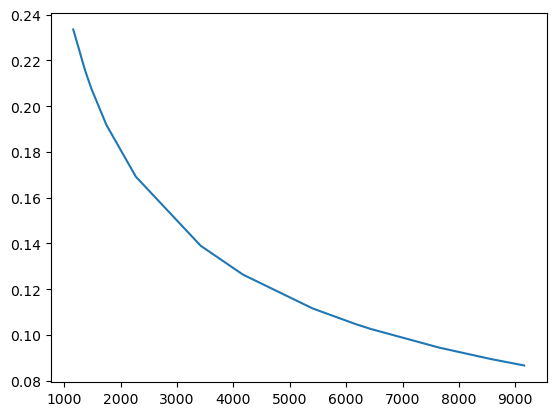

In [18]:
wavelengths = [1157.5, 1367.0, 1478.5, 1746.0, 2268.0, 3419.0, 4168.0, 5404.0, 6176.0, 6440.0, 7648.0, 8561.0, 9157.0]
sfinf = mac10_sf(M/M_sol,abs_mag,np.array(wavelengths))
plt.plot(wavelengths,sfinf)

## Phosim Input 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Created input/3_14_3650/lightcurve_0.icat with magnitude 20.99
Created input/3_14_3650/lightcurve_1.icat with magnitude 20.99
Created input/3_14_3650/lightcurve_2.icat with magnitude 20.98
Created input/3_14_3650/lightcurve_3.icat with magnitude 20.98
Created input/3_14_3650/lightcurve_4.icat with magnitude 20.98
Created input/3_14_3650/lightcurve_5.icat with magnitude 20.98
Created input/3_14_3650/lightcurve_6.icat with magnitude 20.99
Created input/3_14_3650/lightcurve_7.icat with magnitude 20.99
Created input/3_14_3650/lightcurve_8.icat with magnitude 21.00
Created input/3_14_3650/lightcurve_9.icat with magnitude 21.00
Created input/3_14_3650/lightcurve_10.icat with magnitude 21.00
Created input/3_14_3650/lightcurve_11.icat with magnitude 21.00
Created input/3_14_3650/lightcurve_12.icat with magnitude 21.00
Created input/3_14_3650/lightcurve_13.icat with magnitude 21.00
Created input/3_14_3650/lightcurve_14.icat with magnitude 21.00
Created input/3_14_3650/lightcurve_15.icat with ma

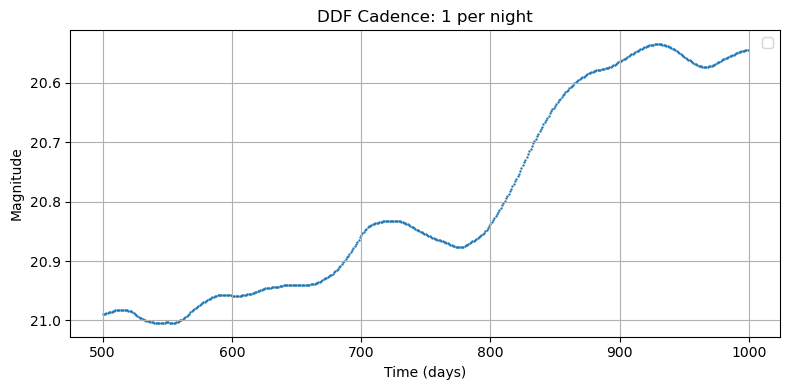

In [24]:
#UGRIZY
wavref_fvf = [[3650,0.13],[4640,0.078],[6580,0.06],[8060,0.071],[9000,0.044],[10200,0.03]]
fig, axs = plt.subplots(1, figsize=(8, 4))
wav_list = wavref_fvf
wav_list = [[3650,0.13]]
fvf = []
trimmed_index = np.where((days >= 0) & (days <= 1000))[0]
ra_coor = 150.1000000
dec_coor = 2.1819444
initial_mjd = 60747
for i, wav in enumerate(wav_list):
    # Calculate the mean and standard deviation of the convolved light curve
    mean_flux = np.mean(normalize_convolved_light_curve)
    std_flux = np.std(normalize_convolved_light_curve)
    sfinf = mac10_sf(M/M_sol,-13,wav[0])
    #print(sfinf, mean_flux*F_nu2mJy,flux_to_magnitude(mean_flux*F_nu2mJy) )
    #print(fvf_cal(sfinf,flux_to_magnitude(mean_flux*F_nu2mJy)))
    # Scale the light curve
    scaled_lc = (normalize_convolved_light_curve - mean_flux) / std_flux
    scaled_lc = scaled_lc * (wav[1] * background_L[i]) + background_L[i]

    trimmed_days  = days[500:1000]
    trimmed_lc = scaled_lc[500:1000]
    
    time = trimmed_days[::4]
    magnitude = fnu_to_abmag(trimmed_lc[::4])

    # Generate an instance catalog for each time step
    for i, (time, mag) in enumerate(zip(time, magnitude)):
        mjd = initial_mjd + time
        filename = f"input/3_14_3650/lightcurve_{i}.icat"
        #filename = f"Data/test/3650/lightcurve_{i}.icat"
        with open(filename, "w") as f:
            f.write(f"rightascension {ra_coor}\n" )
            f.write(f"declination {dec_coor}\n")
            f.write(f"mjd {mjd}\n")
            f.write(f"filter 0\n")
            f.write(f"obstime 15\n")
            f.write(f"numexp 1\n")
            f.write(f"moonalt -90.0\n")
            f.write(f"sunalt -90.0\n")
            f.write(f"obsid {i}\n")
            f.write(f"seed 1000\n")
            f.write(f"object 1 {ra_coor} {dec_coor} {mag:.2f} ../sky/sed_flat.txt 0 0 0 0 0 0 star none none\n")
            f.write(f"object 2 {ra_coor} {dec_coor+0.01} 15 ../sky/sed_flat.txt 0 0 0 0 0 0 star none none\n")
        print(f"Created {filename} with magnitude {mag:.2f}")

    # Plot the scaled light curve
    #axs[0].scatter(days[::1], F_nu2mJy*scaled_lc[::1], s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    #axs[1].scatter(days[::4], F_nu2mJy*scaled_lc[::4], s=0.5, color=color[i], label=f'{int(wav[0])} Å')
    axs.scatter(trimmed_days, fnu_to_abmag(trimmed_lc), s=0.5)
    #axs[1].scatter(time, magnitude, s=0.5, color=color[i], label=f'{int(wav[0])} Å')

    fvf.append(fvf_cal(sfinf, np.mean(flux_to_magnitude(F_nu2mJy*scaled_lc))))
    # Save the scaled light curve to a CSV file

    '''
    with open('Data/Fiducial/z05/' + str(wav) + '_scaled_light_curve.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['time', 'flux [mJy]', 'error'])  # Write the header
        for tau, flux, error in zip(days, scaled_lc, errors):
            csvwriter.writerow([tau, flux, error])
    '''
axs.set_xlabel('Time (days)')
axs.set_ylabel('Magnitude')
axs.set_title('DDF Cadence: 1 per night')
axs.invert_yaxis()
axs.legend()
axs.grid()
plt.tight_layout()
plt.show()

## Image read in 

In [2]:

# Directory containing the subfolders with .gz files
directory = 'Data/test/3650'

# Iterate over each subdirectory in the directory
for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    #print(subdir_path)
    if os.path.isdir(subdir_path):
        # Iterate over each file in the subdirectory
        for filename in os.listdir(subdir_path):
            print(filename)
            if filename.endswith('.gz'):
                # Unzip the file
                gz_path = os.path.join(subdir_path, filename)
                fits_path = os.path.join(subdir_path, filename[:-3])  # Remove the .gz extension
                
                with gzip.open(gz_path, 'rb') as f_in:
                    with open(fits_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
                
                # Open the fits file
                #with fits.open(fits_path) as hdul:
                    # Print the header of the primary HDU
                    #print(hdul[0].header)

generic_e_9999_f0_chip_E000.fits
generic_e_9999_f0_chip_E000.fits.gz
generic_e_9999_f0_chip_E000.fits
generic_e_9999_f0_chip_E000.fits.gz
generic_e_9999_f0_chip_E000.fits
generic_e_9999_f0_chip_E000.fits.gz
generic_e_9999_f0_chip_E000.fits
generic_e_9999_f0_chip_E000.fits.gz
generic_e_9999_f0_chip_E000.fits
generic_e_9999_f0_chip_E000.fits.gz
generic_e_9999_f0_chip_E000.fits
generic_e_9999_f0_chip_E000.fits.gz
generic_e_9999_f0_chip_E000.fits
generic_e_9999_f0_chip_E000.fits.gz
generic_e_9999_f0_chip_E000.fits
generic_e_9999_f0_chip_E000.fits.gz
generic_e_9999_f0_chip_E000.fits
generic_e_9999_f0_chip_E000.fits.gz
generic_e_9999_f0_chip_E000.fits
generic_e_9999_f0_chip_E000.fits.gz
generic_e_9999_f0_chip_E000.fits
generic_e_9999_f0_chip_E000.fits.gz
generic_e_9999_f0_chip_E000.fits
generic_e_9999_f0_chip_E000.fits.gz
generic_e_9999_f0_chip_E000.fits
generic_e_9999_f0_chip_E000.fits.gz
generic_e_9999_f0_chip_E000.fits
generic_e_9999_f0_chip_E000.fits.gz
generic_e_9999_f0_chip_E000.fits
g

Data/3650\0\generic_e_9999_f0_chip_E000.fits
18.01336936760451 -3.0133693676045104
Data/3650\1\generic_e_9999_f0_chip_E000.fits
17.755338143279268 -2.7553381432792667
Data/3650\10\generic_e_9999_f0_chip_E000.fits
20.29078685636147 -5.290786856361471
Data/3650\100\generic_e_9999_f0_chip_E000.fits
19.423589227813284 -4.4235892278132845
Data/3650\101\generic_e_9999_f0_chip_E000.fits
18.98272283363641 -3.98272283363641
Data/3650\102\generic_e_9999_f0_chip_E000.fits
20.558922868108418 -5.558922868108416
Data/3650\103\generic_e_9999_f0_chip_E000.fits
19.757490986895792 -4.757490986895792
Data/3650\104\generic_e_9999_f0_chip_E000.fits
19.91638778129664 -4.9163877812966374
Data/3650\105\generic_e_9999_f0_chip_E000.fits
19.783327860524835 -4.783327860524836
Data/3650\106\generic_e_9999_f0_chip_E000.fits
18.653686974730746 -3.653686974730746
Data/3650\107\generic_e_9999_f0_chip_E000.fits
19.08195541859296 -4.081955418592958
Data/3650\108\generic_e_9999_f0_chip_E000.fits
19.257723410223566 -4.257

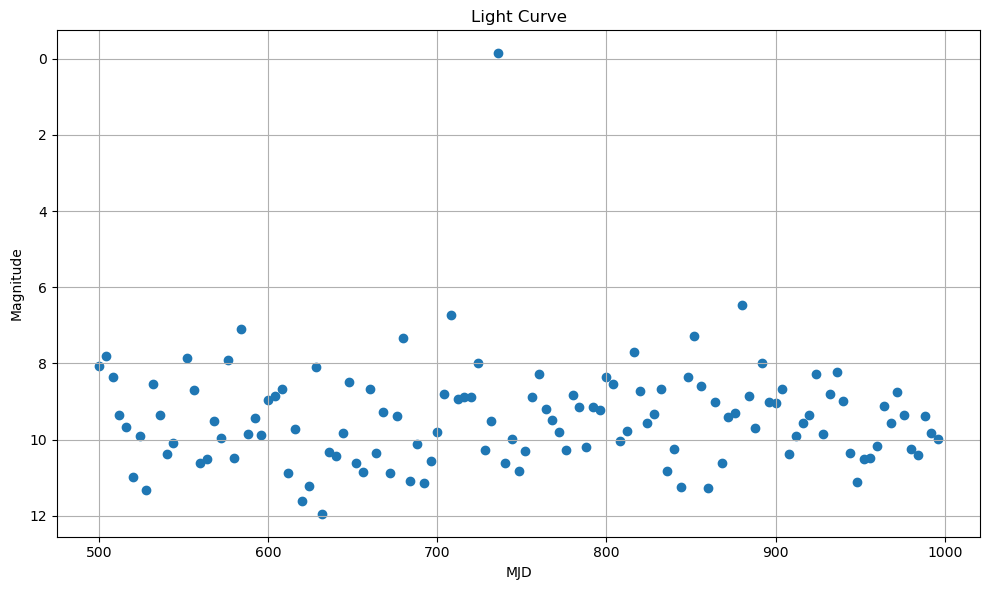

In [60]:

import os
import gzip
import shutil
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAnnulus, CircularAperture, ApertureStats, aperture_photometry

# Function to perform aperture photometry and background subtraction
def perform_photometry(fits_file, positions, aperture_radius, annulus_radii):
    with fits.open(fits_file) as hdul:
        data = hdul[0].data
        apertures = CircularAperture(positions, r=aperture_radius)
        annulus_apertures = CircularAnnulus(positions, r_in=annulus_radii[0], r_out=annulus_radii[1])
        
        phot_table = aperture_photometry(data, apertures)
        bkg_table = aperture_photometry(data, annulus_apertures)
        
        bkg_mean = bkg_table['aperture_sum'] / annulus_apertures.area
        bkg_sum = bkg_mean * apertures.area
        
        flux = phot_table['aperture_sum'] - bkg_sum
        return flux[0]

# Define the positions and aperture radius
positions = [(511, 511),(511, 583)]
#star_position = [(511, 583)]

# Define the aperture radius and annulus radii
aperture_radius = 40  
annulus_radii = (50, 70)  # Inner and outer radii for the annulus
apertures = CircularAperture(positions, r=30.)
annulus_aperture = CircularAnnulus(positions, r_in=40, r_out=50)
# List to store photometry results
photometry_results = []
mjd = []

# Directory containing the subfolders with .gz files
directory = 'Data/3650'

# Iterate over each subdirectory in the directory
for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    if os.path.isdir(subdir_path):
        # Iterate over each file in the subdirectory
        for filename in os.listdir(subdir_path):
            if filename.endswith('.gz'):
                # Unzip the file
                gz_path = os.path.join(subdir_path, filename)
                fits_path = os.path.join(subdir_path, filename[:-3])  # Remove the .gz extension
                #print(gz_path)
                print(fits_path)
                #with gzip.open(gz_path, 'rb') as f_in:
                #    with open(fits_path, 'wb') as f_out:
                #        shutil.copyfileobj(f_in, f_out)

                image1 = fits.open(gz_path)
                imagedata = image1[0].data
                mjd.append(image1[0].header['MJD-OBS'])

                imagedata = image1[0].data
                #mean, median, std = sigma_clipped_stats(imagedata, sigma=5.0)
                #daofind = DAOStarFinder(fwhm=5.0, threshold=5.*std)
                #sources = daofind(imagedata - median)
                #print((np.transpose((sources['xcentroid'], sources['ycentroid']))))
                
                # Define the apertures
                aperstats = ApertureStats(imagedata, annulus_aperture)
                bkg_mean = aperstats.mean
                aperture_area = apertures.area_overlap(imagedata)
                total_bkg = bkg_mean*aperture_area

                # perform aperture photometry
                star_data = aperture_photometry(imagedata, apertures)
                #print(star_data)
                # add backgrounds to table
                star_data['total_bkg'] = total_bkg

                # Perform photometry
                # Callibration Star
                cal_star_mag = 15
                instru_mag = -2.5 * np.log10(np.array(abs(star_data[1]['aperture_sum']-star_data[1]['total_bkg']))/15)
                zp_mag = cal_star_mag - instru_mag  
                print(zp_mag, instru_mag)
                photometry_value = -2.5 * np.log10(np.array(abs(star_data[0]['aperture_sum']-star_data[0]['total_bkg']))/15) + zp_mag
                photometry_results.append(photometry_value)

# Convert flux to magnitude
#magnitudes = -2.5 * np.log10(np.array(photometry_results)/15) + 26


# Plot the light curve
plt.figure(figsize=(10, 6))
plt.scatter(mjd, photometry_results, marker='o', linestyle='-')
#plt.scatter(mjd, photometry_results, marker='o')
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.title('Light Curve')
plt.gca().invert_yaxis()  # Invert y-axis to have brighter magnitudes at the top
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
image1 = fits.open('Data/3650/100/generic_e_9999_f0_chip_E000.fits.gz')
image1.info()
image1[0].header

Filename: Data/3650/100/generic_e_9999_f0_chip_E000.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     403   (1024, 1024)   float32   


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1024 / length of data axis 1                          
NAXIS2  =                 1024 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CTYPE1  = 'RA---TAN'                                                            
CRPIX1  =                 512.                                                  
CRVAL1  =                   0.                                                  
CTYPE2  = 'DEC--TAN'                                                            
CRPIX2  =                 51

In [39]:
print('filter type:', image1[0].header['FILTER'])
print('exposure time:', image1[0].header['EXPTIME'])
cdelt1 = image1[0].header['CD1_1']
cdelt2 = image1[0].header['CD1_2']
# Calculate the image scale (arcsec/pixel)
image_scale = abs(cdelt2)  # Assuming CDELT1 is in arcseconds/pixel

# Example: Convert arcseconds to pixels
arcseconds = 0.5
pixel_size = arcseconds / image_scale
print(f"The image scale is {image_scale} arcsec/pixel")
print(f"{arcseconds} arcseconds corresponds to {pixel_size} pixels")

filter type: ( <
exposure time: 15.0
The image scale is 0.000146204491344662 arcsec/pixel
0.5 arcseconds corresponds to 3419.867579999999 pixels


In [45]:

imagedata = image1[0].data
mean, median, std = sigma_clipped_stats(imagedata, sigma=5.0)
print(f"Mean: {mean:.2f}, Median: {median:.2f}, Std: {std:.2f}")


daofind = DAOStarFinder(fwhm=5.0, threshold=5.*std)
sources = daofind(imagedata - median)
if sources is not None:
    for col in sources.colnames:
        if col not in ('id', 'npix'):
            sources[col].info.format = '%.2f'  # for consistent table output
    sources.pprint(max_width=76)
else:
    print("No sources found.")


Mean: 148.46, Median: 148.00, Std: 12.47
 id xcentroid ycentroid sharpness roundness1 ... sky    peak   flux   mag 
--- --------- --------- --------- ---------- ... ---- ------- ------ -----
  1    511.55    511.51      0.78       0.25 ... 0.00 6027.00 113.48 -5.14
  2    312.75    785.84      0.21       0.38 ... 0.00   15.00   1.01 -0.01
  3    511.67    853.03      0.84      -0.01 ... 0.00 1123.00  20.33 -3.27


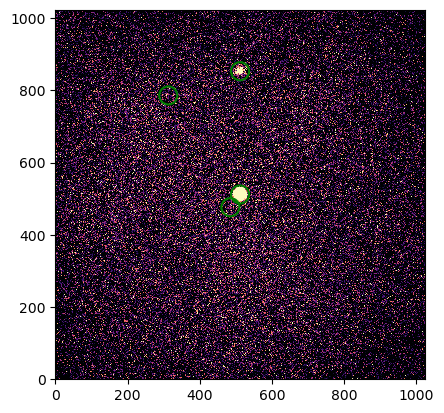

In [41]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=25.0)
#norm = ImageNormalize(stretch=SqrtStretch())
vlo = np.percentile(imagedata,60) # set lower display limit to median (sky) 
vhi = np.percentile(imagedata,99) # set upper display limit to 99th percentile 
plt.imshow(imagedata, cmap='magma', origin='lower',vmin=vlo,vmax=vhi,
           interpolation='nearest')
apertures.plot(color='green', lw=1.5, alpha=1)

In [48]:


imagedata = image1[0].data
threshold = 500      #Enter a threshold which seems suitable to you
tbl = find_peaks(imagedata, threshold, box_size=10) #Photutils will find peaks above the given threshold

if tbl is not None:
	tbl['peak_value'].info.format = '%.8g'
	print(tbl)
else:
	print("No peaks found above the threshold.")

x_peak y_peak peak_value
------ ------ ----------
   511    512       4440
   873    766        937
   511    853       1216


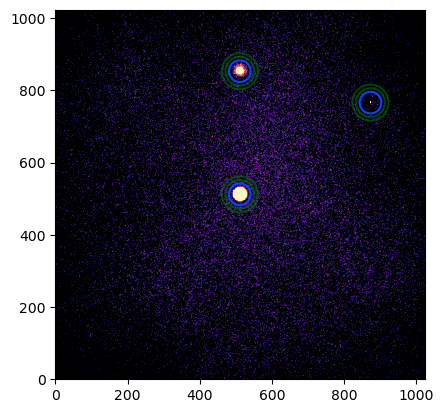

In [49]:
positions = np.transpose((tbl['x_peak'], tbl['y_peak'])) # Read XY positions from table.
apertures = CircularAperture(positions, r=30.) #Takes the positions from above.
vlo = np.percentile(imagedata,50) # set lower display limit to median (sky) 
vhi = np.percentile(imagedata,99) # set upper display limit to 99th percentile 
plt.imshow(imagedata,origin='lower', cmap='magma',vmin=vlo,vmax=vhi) # Display the image.
annulus_aperture = CircularAnnulus(positions, r_in=40, r_out=50)
annulus_aperture.plot(color='green',lw=1.5,alpha=0.5)
apertures.plot(color='#0547f9', lw=1.5) # Plot small circles around all of the positions from above
plt.show()

In [13]:
# define background
aperstats = ApertureStats(imagedata, annulus_aperture)
bkg_mean = aperstats.mean
aperture_area = apertures.area_overlap(imagedata)
total_bkg = bkg_mean*aperture_area

# perform aperture photometry
star_data = aperture_photometry(imagedata, apertures)

# add backgrounds to table
star_data['total_bkg'] = total_bkg

# format and print data
for col in star_data.colnames:
    star_data[col].info.format = '%.8g'
star_data.pprint()

 id xcenter ycenter aperture_sum total_bkg
      pix     pix                         
--- ------- ------- ------------ ---------
  1     511     511    204515.34 63986.265


Data/test/3650\99\generic_e_9999_f0_chip_E000.fits


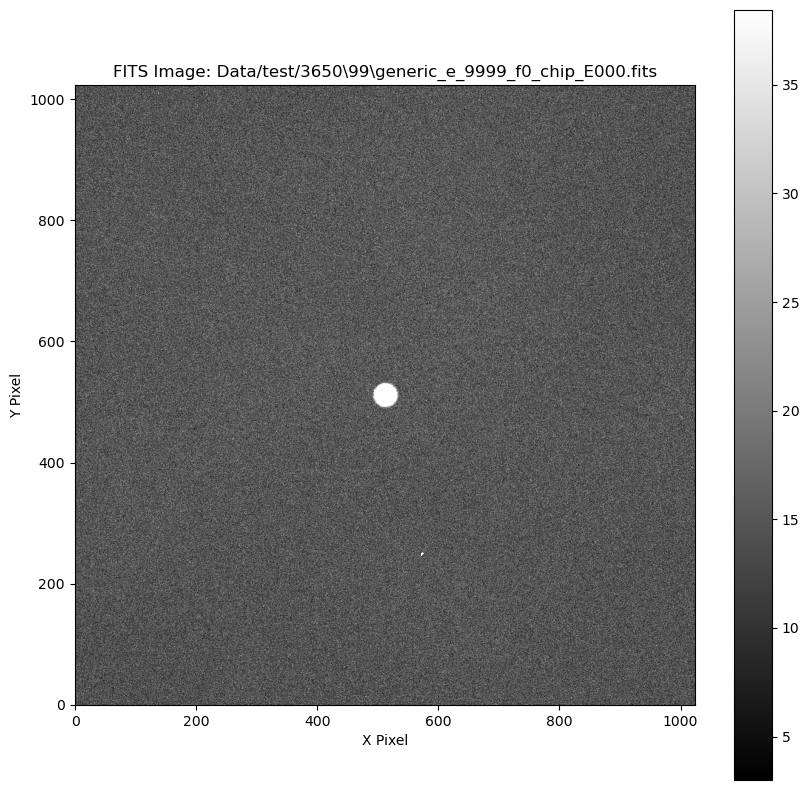

In [3]:
from astropy.visualization import ZScaleInterval, ImageNormalize
print(fits_path)
# Function to display the FITS image
def display_fits_image(fits_file):
    with fits.open(fits_file) as hdul:
        data = hdul[0].data

        # Normalize the image using ZScaleInterval
        norm = ImageNormalize(data, interval=ZScaleInterval())

        plt.figure(figsize=(10, 10))
        plt.imshow(data, cmap='gray', origin='lower', norm=norm)
        plt.colorbar()
        plt.title(f'FITS Image: {fits_file}')
        plt.xlabel('X Pixel')
        plt.ylabel('Y Pixel')
        plt.show()

# Display the FITS image
display_fits_image(fits_path)

In [22]:
import numpy as np

# Define parameters
period = 1.0  # intrinsic period of the variable star in days
num_cycles = 5  # number of cycles to simulate
sampling_rate = 0.01  # time between observations in days

# Create rest-frame time array
t_rest = np.arange(0, period * num_cycles, sampling_rate)

# Define the light curve function (e.g., sinusoidal variability)
def light_curve(t, amplitude=1.0, mean=0.0):
    return amplitude * np.sin(2 * np.pi * t / period) + mean

# Generate the rest-frame light curve
lc_rest = light_curve(t_rest)

# Define redshifts to simulate
redshifts = [0.5, 1, 2.0]

# Dictionary to store observed time arrays and light curves
observed_data = {}

for z in redshifts:
    # Calculate observed time array
    t_observed = t_rest * (1 + z)

    # Store the observed time array and corresponding light curve
    observed_data[z] = {
        'time': t_observed,
        'light_curve': lc_rest  # same intrinsic light curve
    }

from scipy.interpolate import interp1d

# Define a common time grid (e.g., based on the highest redshift)
common_time_grid = np.arange(0, period * num_cycles * (1 + max(redshifts)), sampling_rate)

# Dictionary to store interpolated light curves
interpolated_data = {}

for z in redshifts:
    # Interpolate the light curve onto the common time grid
    interp_func = interp1d(observed_data[z]['time'], observed_data[z]['light_curve'], kind='linear', fill_value='extrapolate')
    interpolated_lc = interp_func(common_time_grid)

    # Store the interpolated light curve
    interpolated_data[z] = {
        'time': common_time_grid,
        'light_curve': interpolated_lc
    }


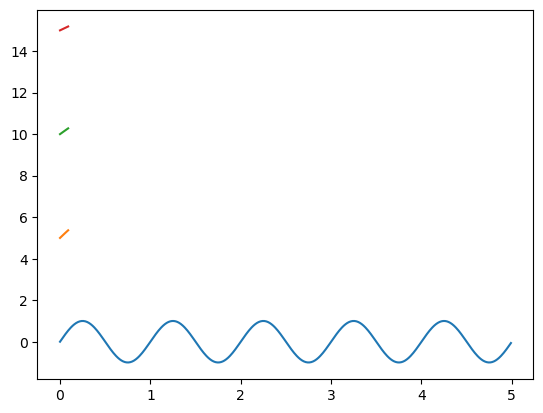

In [26]:
plt.plot(t_rest, lc_rest, label='Rest Frame')
plt.plot(interpolated_data[0.5]['time'][:10], interpolated_data[0.5]['light_curve'][:10]+5, label='z=0.5')
plt.plot(interpolated_data[1]['time'][:10], interpolated_data[1]['light_curve'][:10]+10, label='z=1')
plt.plot(interpolated_data[2.0]['time'][:10], interpolated_data[2.0]['light_curve'][:10]+15, label='z=2')




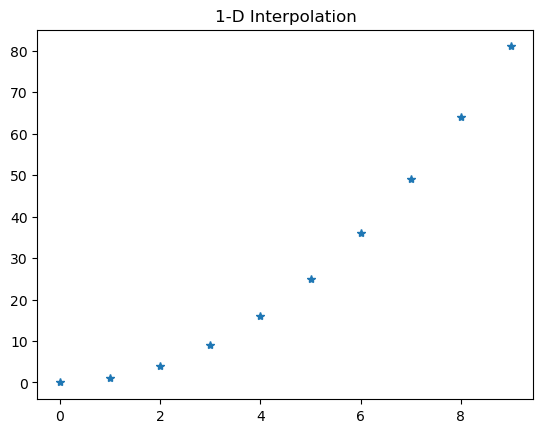

In [56]:
# Initialize input values x and y 
x = np.arange(0, 10) 
y = x**2
  
# Interpolation 
temp = interp1d(x, y) 
xnew = np.arange(0, 9, 0.2) 
ynew = temp(xnew) 
  
plt.title("1-D Interpolation") 
plt.plot(x, y, '*')
#plt.plot(xnew, ynew, 'x', color="green") 
plt.show() 